In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
tfd = tfp.distributions
from tqdm import tqdm_notebook as tqdm, trange

In [4]:
from sklearn.datasets import fetch_olivetti_faces

In [10]:
?fetch_olivetti_faces

In [5]:
face_data = fetch_olivetti_faces()

In [12]:
def calculate_doc_probs2(d_probs, t_logits):
    res = d_probs@tf.math.softmax(t_logits, axis = -1)
    return res

In [17]:
@tf.function
def multiply_by_fisher_inv(alphas, x):
    # alphas is of shape (N, D)
    # x of shape (N, D)
    alpha0 = tf.reduce_sum(alphas, axis=-1, keepdims = True)
    dg_a0 = tf.math.polygamma(1., alpha0)
    dg_a = tf.math.polygamma(1., alphas)
    inv_dg_a = 1/dg_a
    
    # first get the multiply by inv diag matrix
    A_inv_mul_x = inv_dg_a * x
    Corr_top_mul_x = inv_dg_a * tf.reduce_sum(A_inv_mul_x, axis=-1, keepdims=True) # (N, D) * (N, 1)
    Corr_bot = 1/(-dg_a0) + tf.reduce_sum(inv_dg_a, axis = -1, keepdims = True)
    Corr_mul_x = Corr_top_mul_x/Corr_bot
    
    return A_inv_mul_x - Corr_mul_x

@tf.custom_gradient
def natural_gradient_on_backprop(a, ):
    def grad(da):
#         Ia = dirichlet_fisher_inv(a)
#         da_tilde = tf.einsum("tmn,tn->tm", Ia, da)
        da_tilde = multiply_by_fisher_inv(a, da)
        return da_tilde
    return tf.identity(a), grad

In [16]:
f_data_array = face_data['data']
f_norm = lambda d: (d-np.mean(d, axis=0, keepdims=True))/np.std(d, axis=0, keepdims=True)
f_inv_norm = lambda z, d: z*np.std(d, axis=0, keepdims=True) + np.mean(d, axis=0, keepdims=True)
f_data_norm = f_norm(f_data_array)

In [299]:
T = 50
N = 400
V = 4096
S = 100
w_logits = tf.Variable(tf.initializers.GlorotUniform()((N, T)))
h_logits = tf.Variable(tf.initializers.GlorotUniform()((T, N)))
opt = tf.optimizers.Adam(1e-2)

In [300]:
def calculate_doc_probs(d_logits, t_logits):
    res = tf.math.softmax(d_logits, axis = -1)@tf.math.softmax(t_logits, axis = -1)
    return res

In [301]:
epochs = 4000
loss_records = []
tqdm_range = tqdm(range(epochs))
used_data = f_data_norm

for e in tqdm_range:
    i = np.random.choice(np.arange(N), size=S, replace=False)
    with tf.GradientTape() as tape:
        prob_mat = calculate_doc_probs(tf.gather(w_logits, i, axis = 0), h_logits)
        loss = tf.keras.losses.MAE(prob_mat@used_data, used_data[i, :])
    
    grads = tape.gradient(loss, [w_logits, h_logits])
    opt.apply_gradients(zip(grads, [w_logits, h_logits]))
    loss_records.append(tf.reduce_sum(loss))
    tqdm_range.set_description("loss: {:.2f}".format(tf.reduce_sum(loss).numpy()), refresh = True)

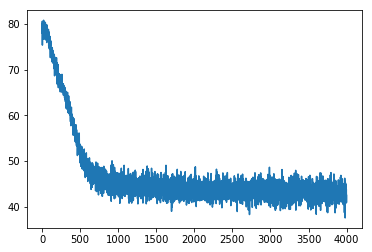

In [302]:
plt.plot(loss_records)
plt.show()

In [303]:
# for t in range(T):
#     plt.bar(np.arange(N), tf.math.softmax(h_logits[t, :]))
#     plt.title('archetype {}'.format(t))
#     plt.show()

Let's randomly sample some reconstructed faces

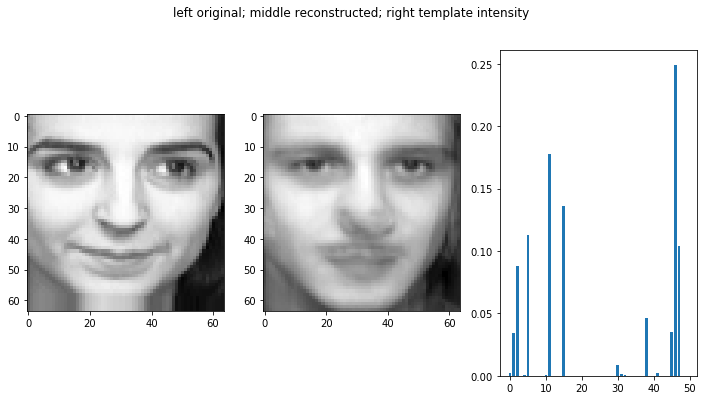

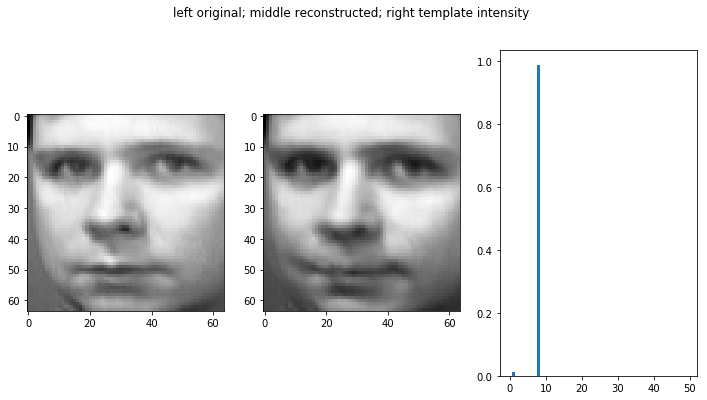

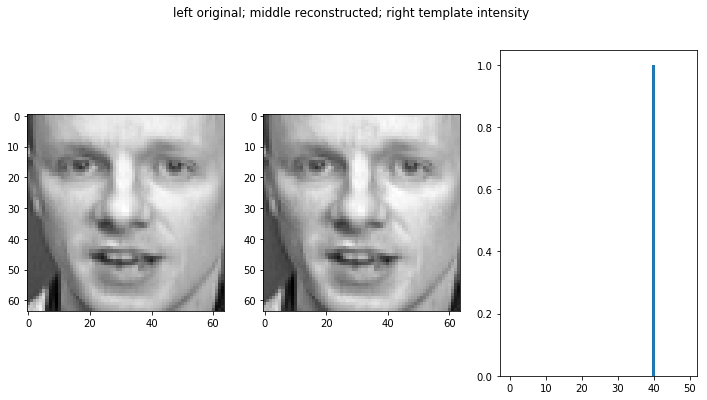

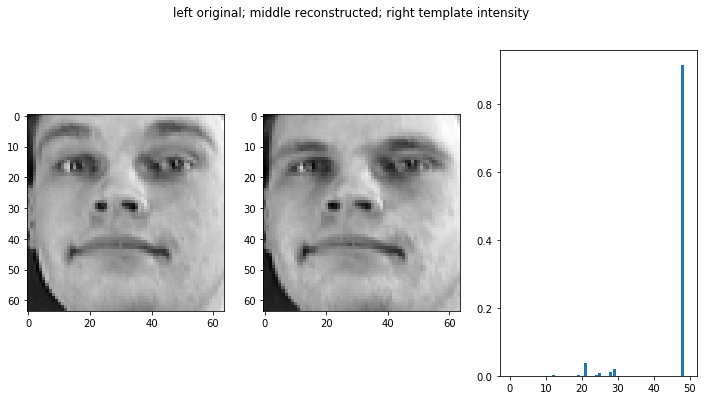

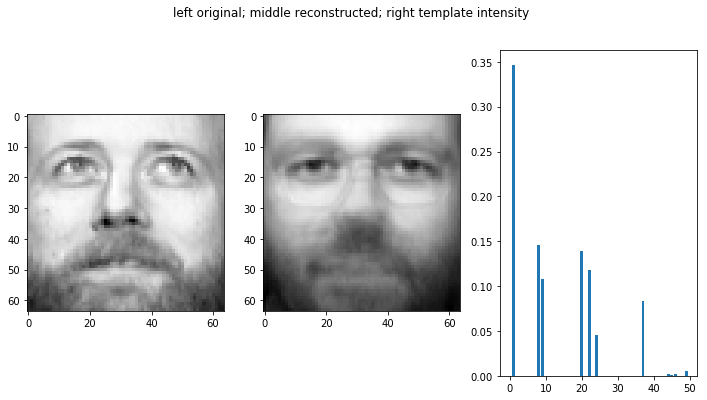

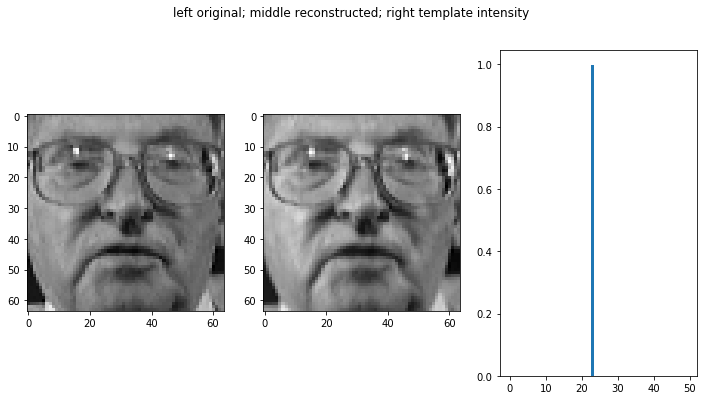

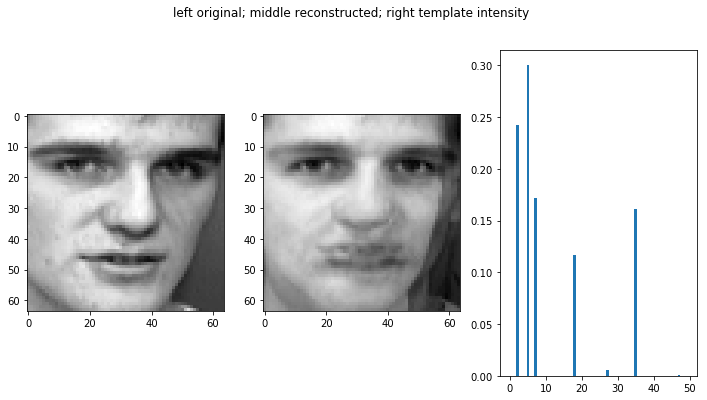

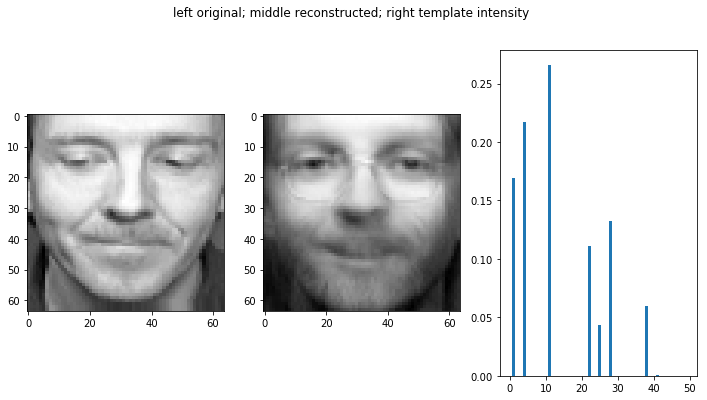

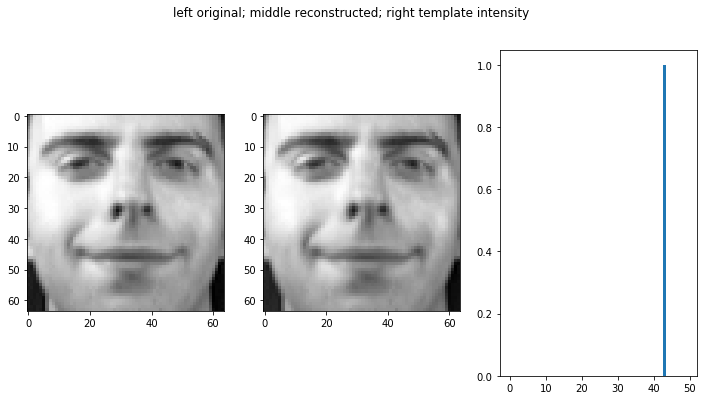

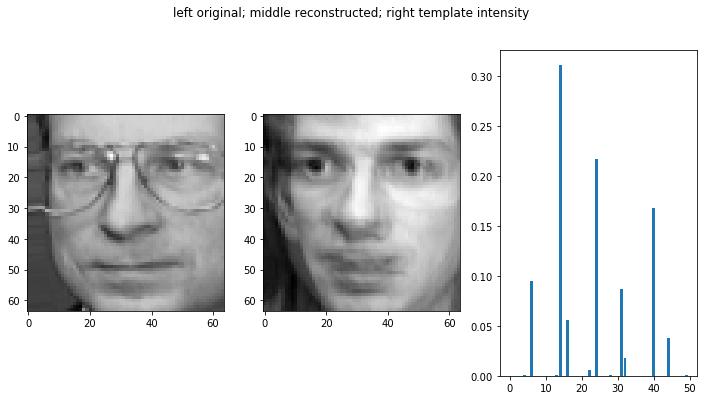

In [304]:
S = 10
sampled_inds = np.random.choice(np.arange(N), size=S, replace=False)


# sampled_reconstruction = calculate_doc_probs(tf.gather(w_logits, sampled_inds, axis = 0), h_logits)@f_data_array
z_reconstruction = calculate_doc_probs(tf.gather(w_logits, sampled_inds, axis = 0), h_logits)@f_data_norm
sampled_reconstruction = f_inv_norm(z_reconstruction, f_data_array)

for s in range(S):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,6))
    fig.suptitle('left original; middle reconstructed; right template intensity')
    x_hat = sampled_reconstruction[s, :].numpy()
    x = f_data_array[sampled_inds[s], :]
    ax1.imshow(np.reshape(-x, (64, 64)), cmap=plt.cm.binary)
    ax2.imshow(np.reshape(-x_hat, (64, 64)), cmap=plt.cm.binary)
    ax3.bar(np.arange(T), tf.math.softmax(tf.gather(w_logits, sampled_inds[s], axis = 0)))
    plt.show()

The Bayesian version

In [517]:
T = 50
N = 400
V = 4096
S = 100
w_logits = tf.Variable(tf.initializers.GlorotUniform()((N, T)))
h_logits = tf.Variable(tf.initializers.GlorotUniform()((T, N)))
opt = tf.optimizers.Adam(1e-2)

w_p = 1.0
w_prior = tfd.Dirichlet(tf.ones((T, )) * w_p)

Trained without the KL divergence term

In [518]:
epochs = 4000
loss_records = []
tqdm_range = tqdm(range(epochs))
used_data = f_data_norm

for e in tqdm_range:
    i = np.random.choice(np.arange(N), size=S, replace=False)
    with tf.GradientTape() as tape:
        w_logits_i = tf.gather(w_logits, i, axis = 0)
        w_post_i = tfd.Dirichlet(tf.math.softmax(w_logits_i, axis = -1) * w_p)
        w_sample = w_post_i.sample()
        prob_mat = calculate_doc_probs2(w_sample, h_logits)
        kl = tfd.kl_divergence(w_post_i, w_prior)
        loss = tf.keras.losses.MAE(prob_mat@used_data, used_data[i, :])
    
    grads = tape.gradient(loss, [w_logits, h_logits])
    opt.apply_gradients(zip(grads, [w_logits, h_logits]))
    loss_records.append(tf.reduce_sum(loss))
    tqdm_range.set_description("loss: {:.2f}".format(tf.reduce_sum(loss).numpy()), refresh = True)

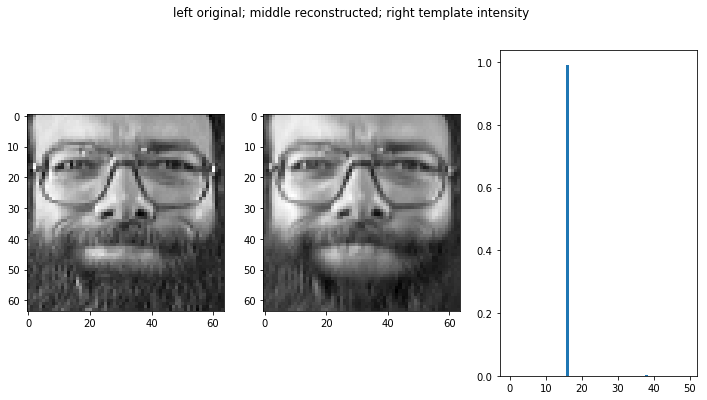

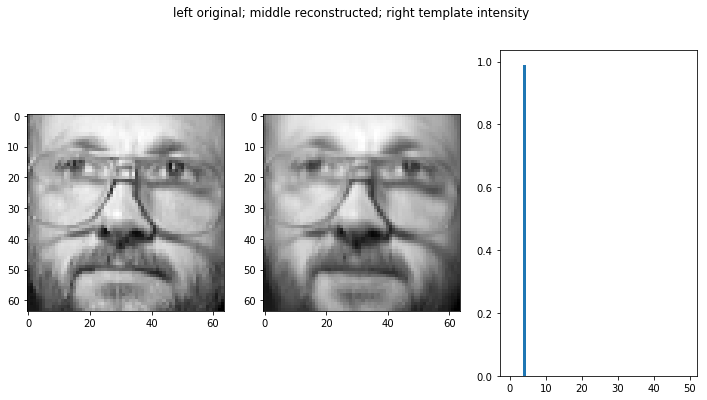

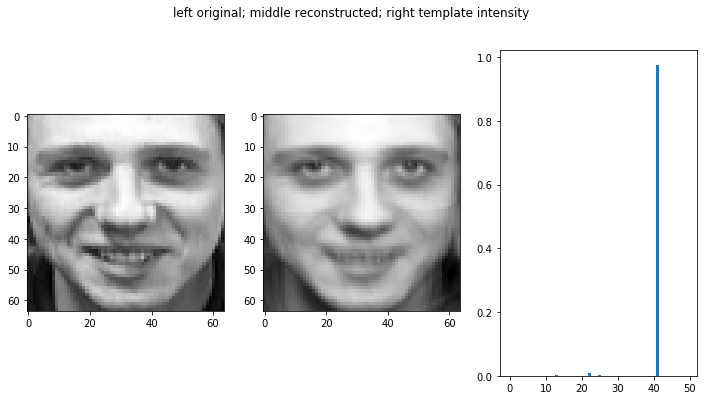

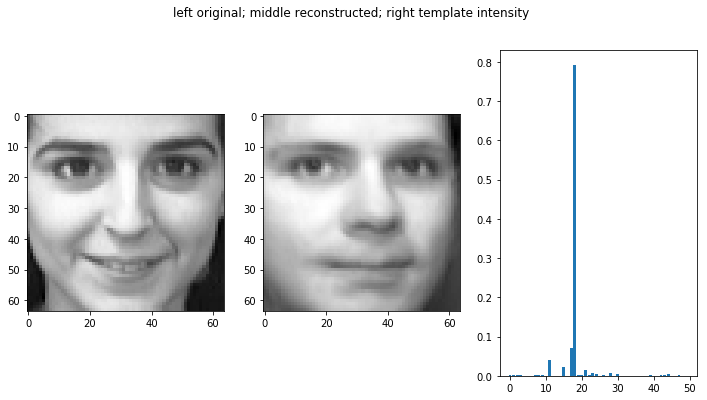

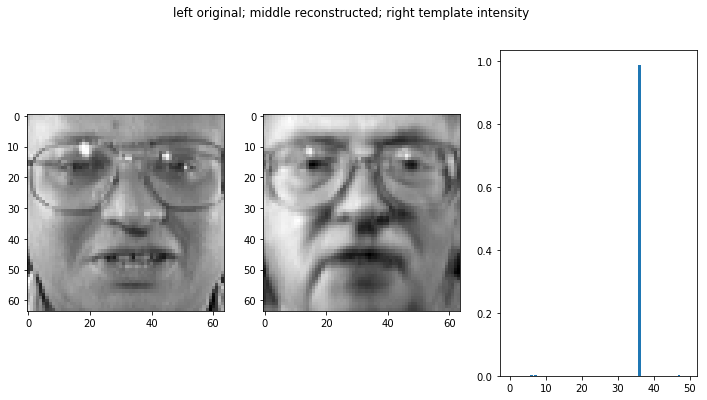

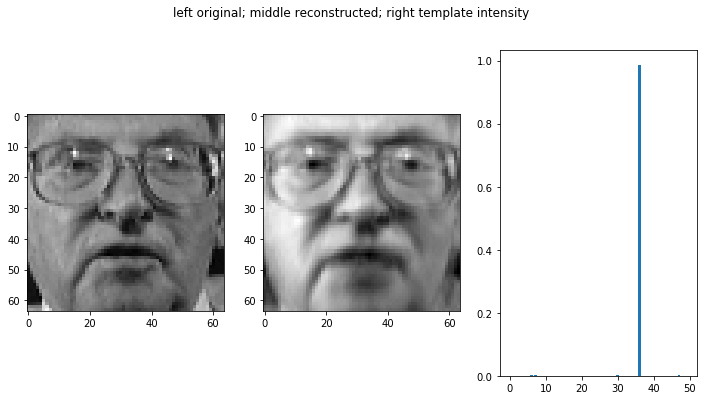

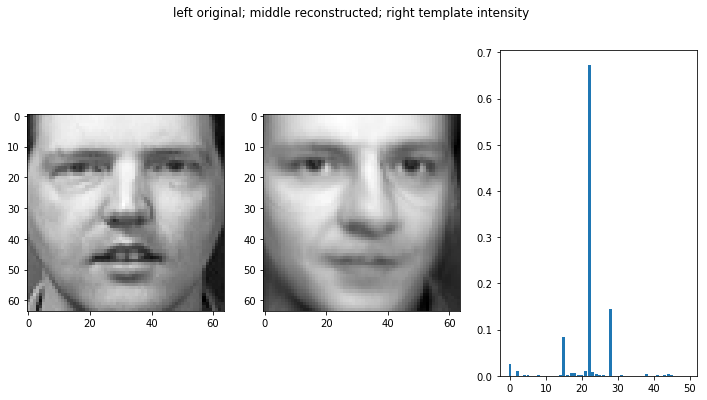

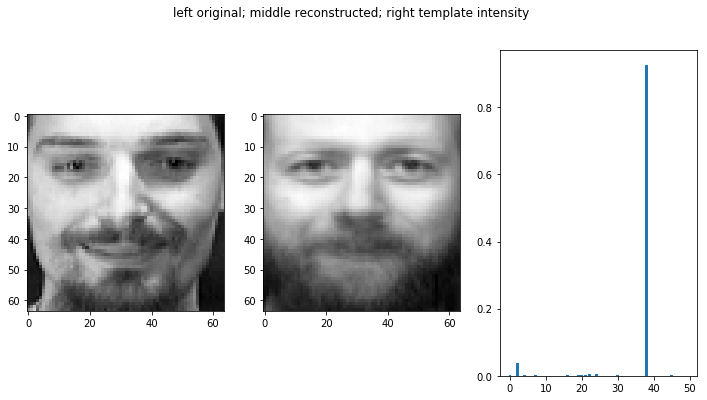

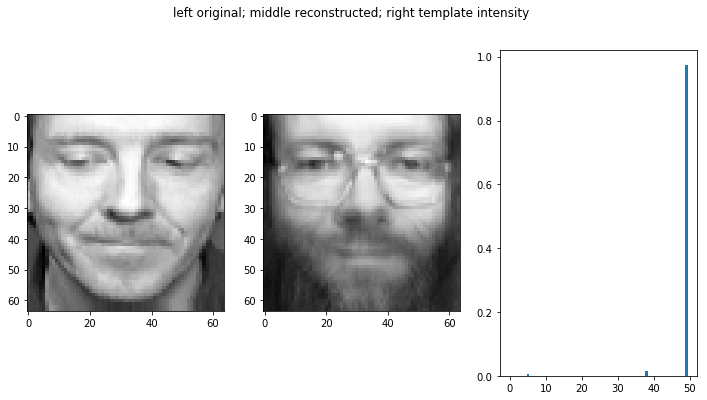

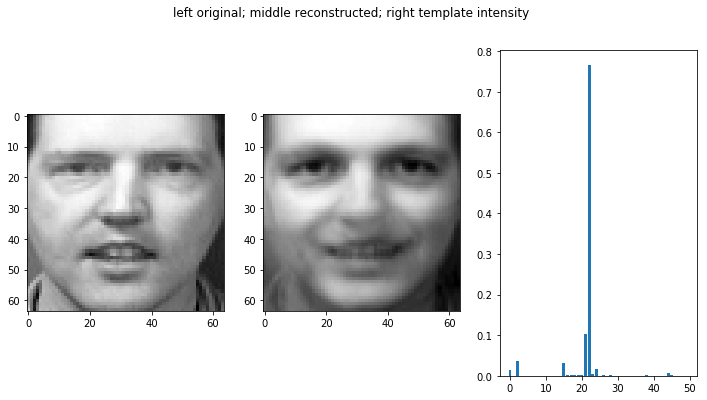

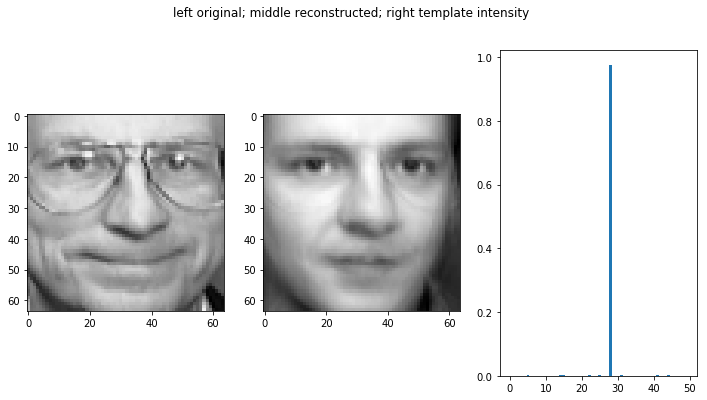

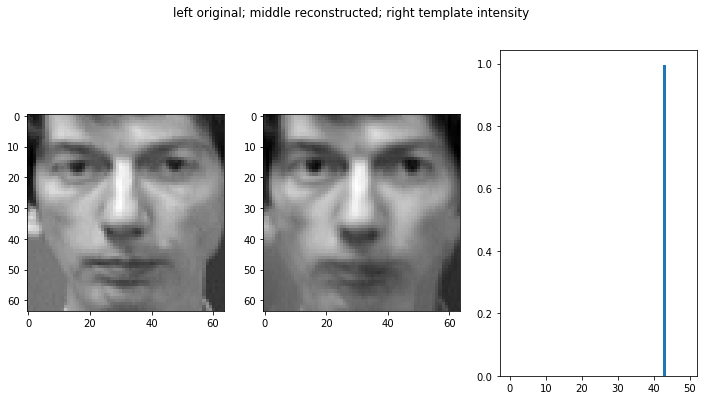

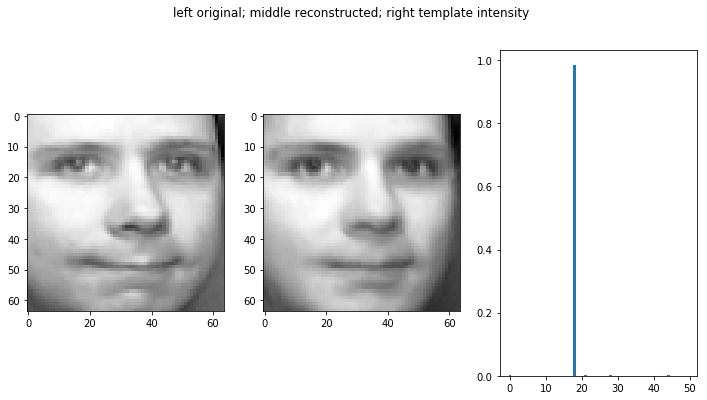

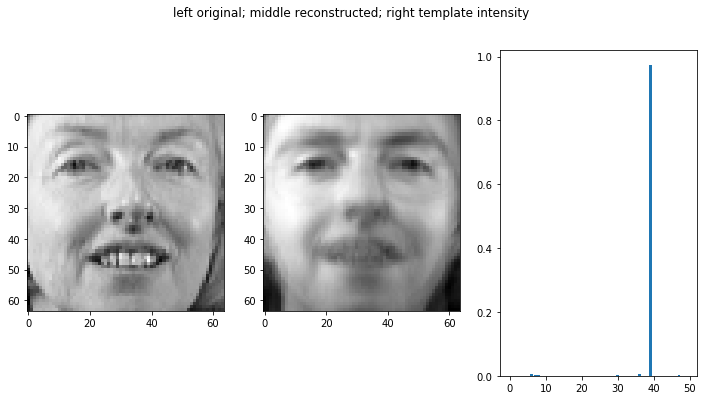

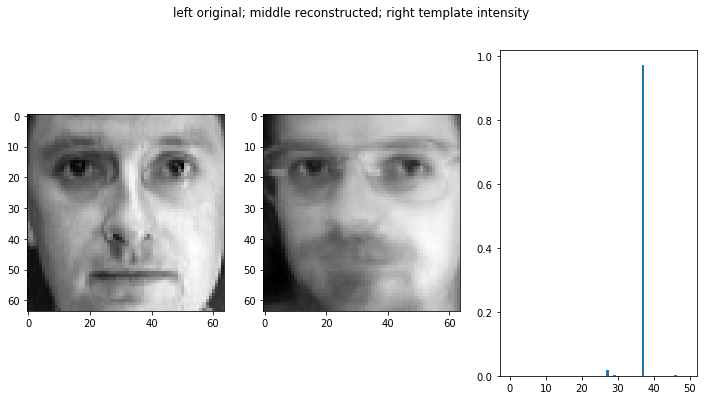

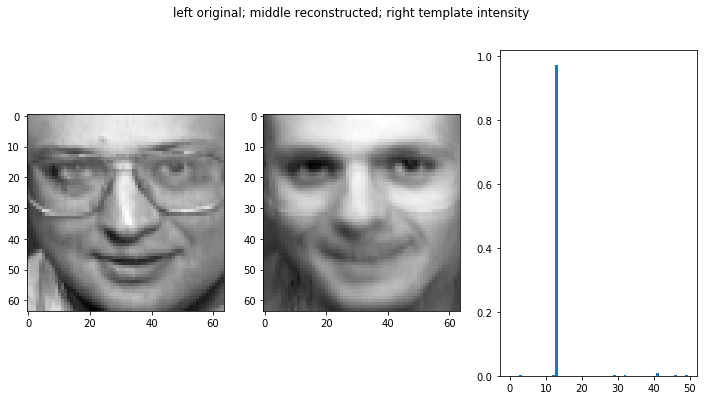

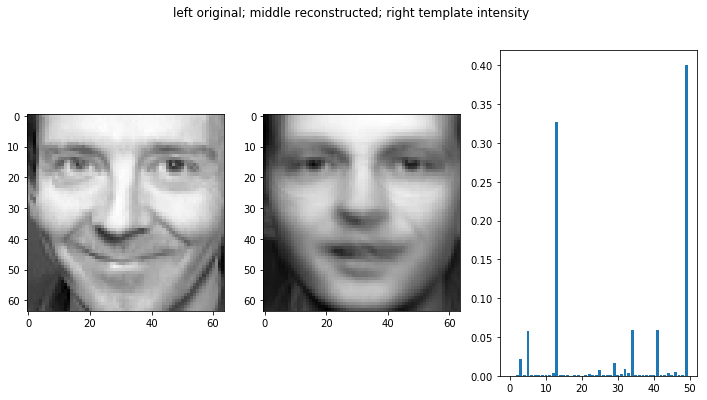

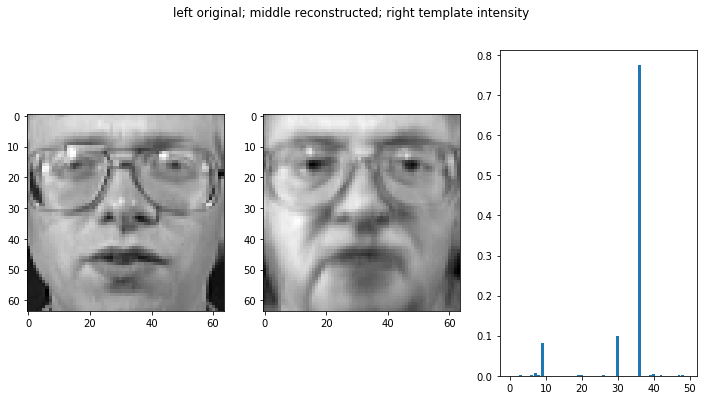

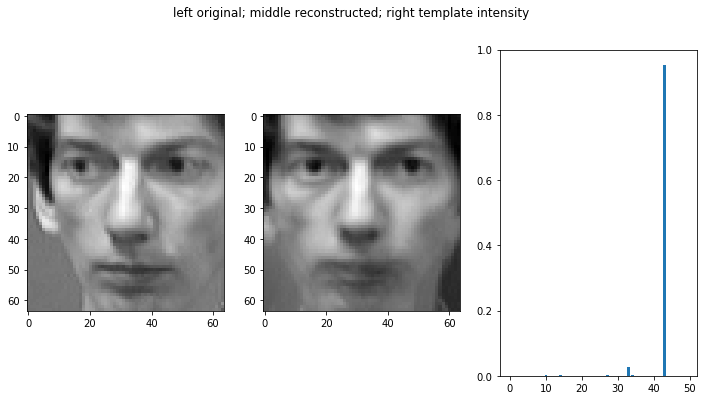

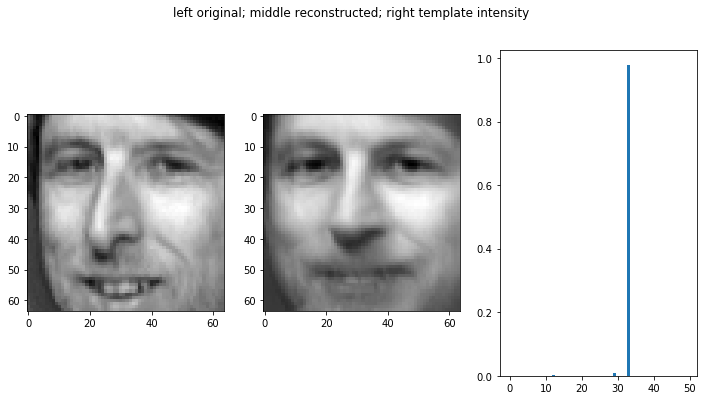

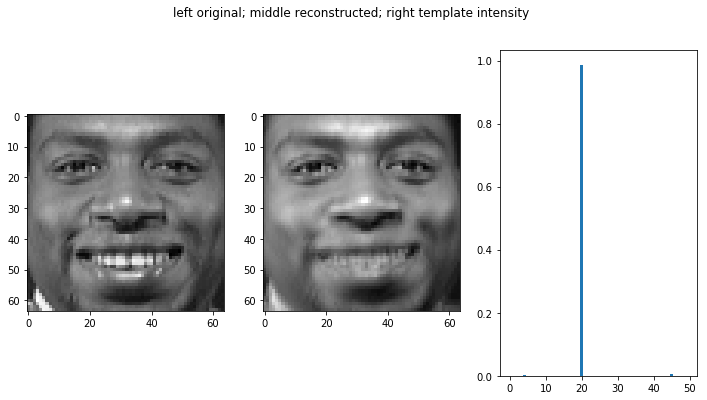

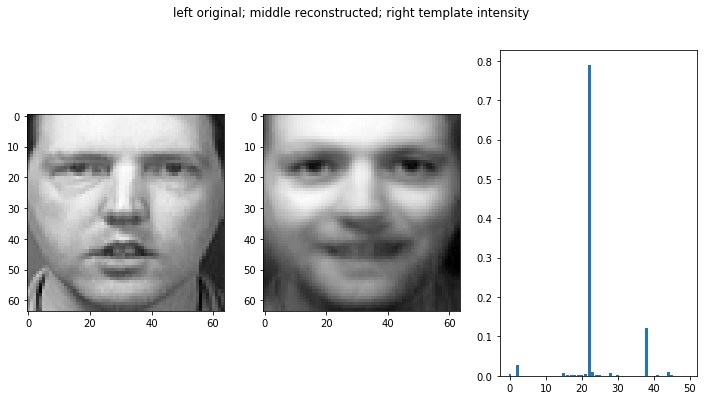

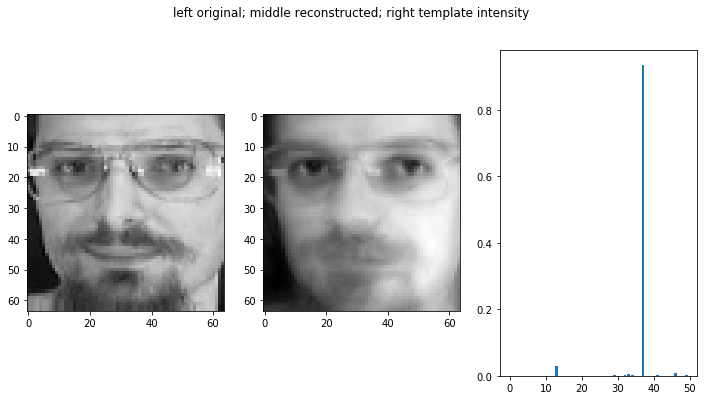

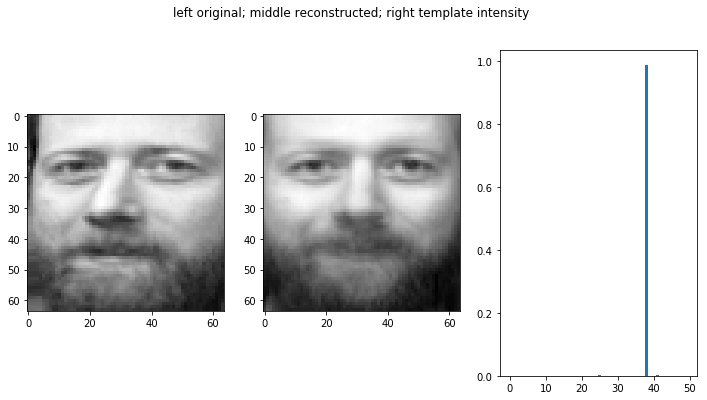

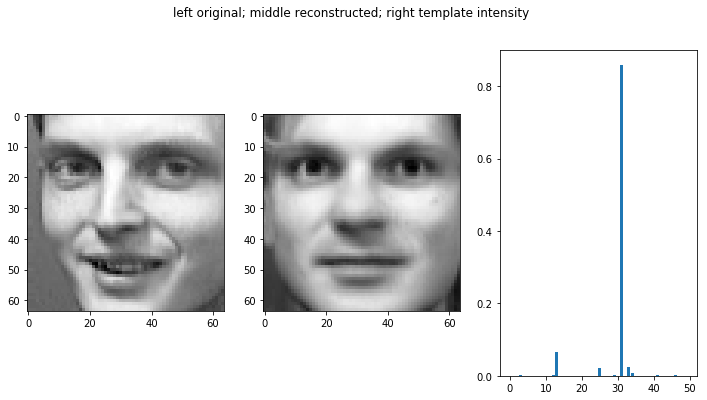

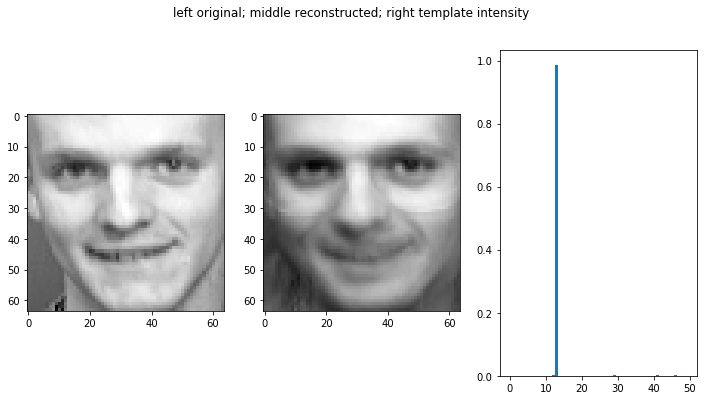

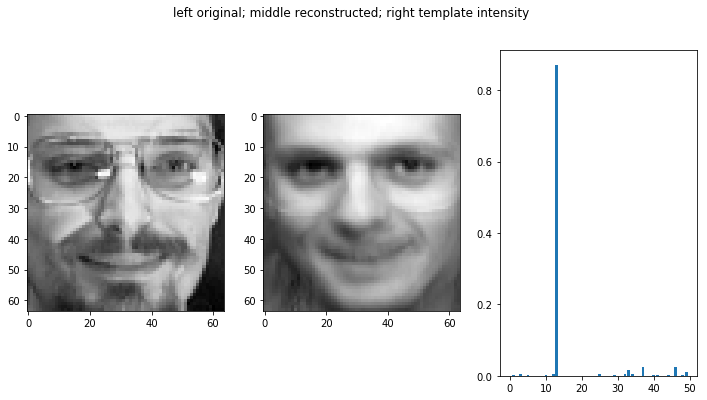

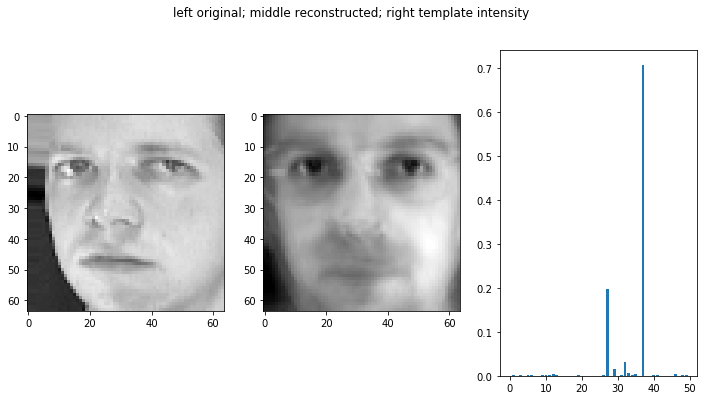

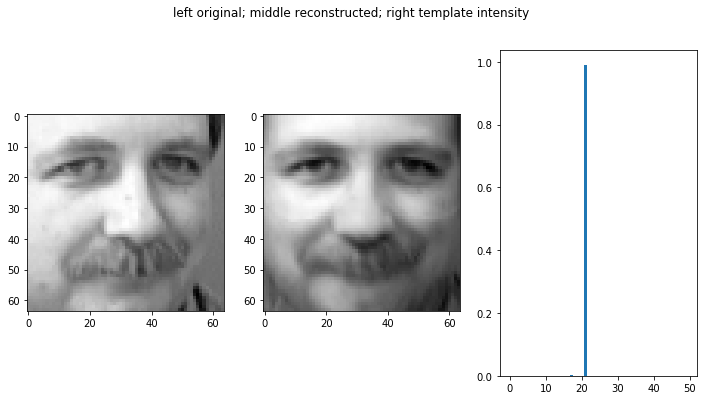

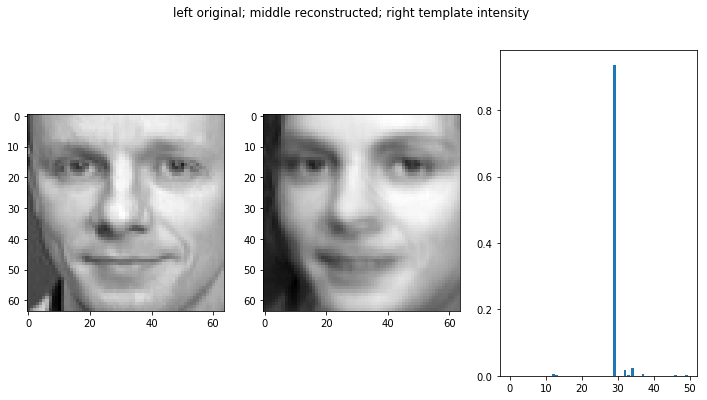

In [519]:
S = 30
sampled_inds = np.random.choice(np.arange(N), size=S, replace=False)

w_logits_i = tf.gather(w_logits, sampled_inds, axis = 0)
w_post_i = tfd.Dirichlet(tf.math.softmax(w_logits_i, axis = -1) * w_p)
w_sample = w_post_i.sample()
x_hats = calculate_doc_probs2(w_sample, h_logits)@used_data

for s in range(S):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,6))
    fig.suptitle('left original; middle reconstructed; right template intensity')
    x_hat = f_inv_norm(x_hats[s, :], f_data_array)
    x = f_data_array[sampled_inds[s], :]
    ax1.imshow(np.reshape(-x, (64, 64)), cmap=plt.cm.binary)
    ax2.imshow(np.reshape(-x_hat, (64, 64)), cmap=plt.cm.binary)
    ax3.bar(np.arange(T), tf.math.softmax(tf.gather(w_logits_i, s, axis = 0)))
    plt.show()

Trained with the KL divergence term

In [100]:
T = 50
N = 400
V = 4096
S = 20
w_logits = tf.Variable(tf.initializers.GlorotUniform()((N, T)))
h_logits = tf.Variable(tf.initializers.GlorotUniform()((T, N)))
opt = tf.optimizers.Adam(1e-1)

w_p = 1.
w_prior = tfd.Dirichlet(tf.ones((T, )) * w_p)

In [101]:
epochs = int(400/20)*100
loss_records = []
tqdm_range = tqdm(range(epochs))
used_data = f_data_norm
# anneal_kl = tf.constant(np.logspace(-9, -4, epochs), 'float32')
natgrad = True

for e in tqdm_range:
    i = np.random.choice(np.arange(N), size=S, replace=False)
    with tf.GradientTape() as tape:
        w_logits_i = tf.gather(w_logits, i, axis = 0)
        if natgrad:
            w_post_i = tfd.Dirichlet(natural_gradient_on_backprop(tf.math.softplus(w_logits_i, )))
        else:
            w_post_i = tfd.Dirichlet(tf.math.softplus(w_logits_i, ))
        w_sample = w_post_i.sample()
        prob_mat = calculate_doc_probs2(w_sample, h_logits)
        kl = tfd.kl_divergence(w_post_i, w_prior)
        loss = tf.reduce_mean(tf.keras.losses.MAE(prob_mat@used_data, used_data[i, :]) + kl)*N
    
    grads = tape.gradient(loss, [w_logits, h_logits])
    opt.apply_gradients(zip(grads, [w_logits, h_logits]))
    loss_records.append(tf.reduce_sum(loss))
    tqdm_range.set_description("loss: {:.2f}".format(tf.reduce_sum(loss).numpy()), refresh = True)

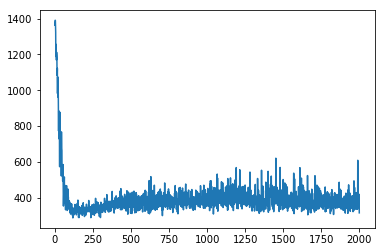

In [92]:
plt.plot(loss_records)
plt.show()

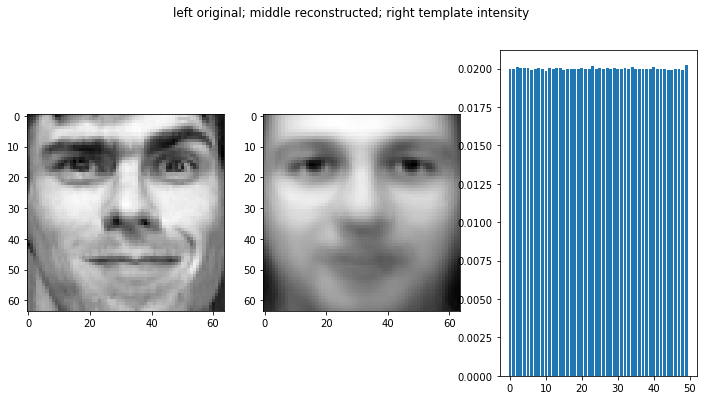

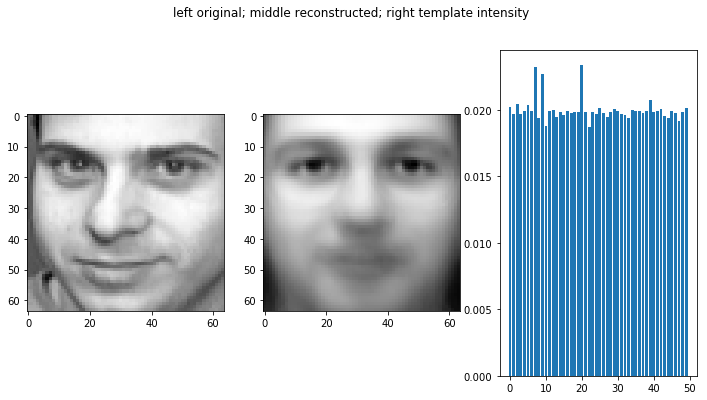

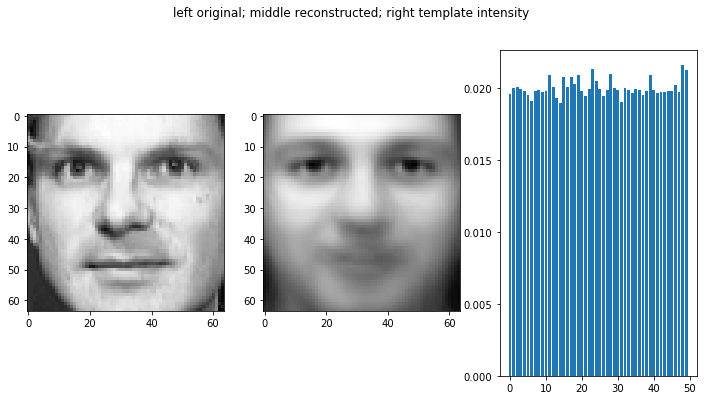

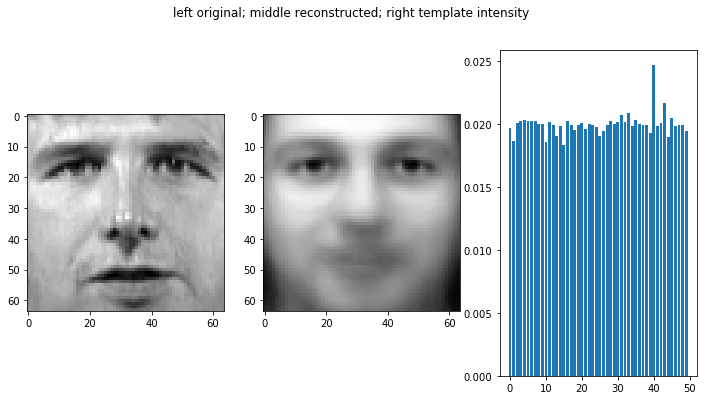

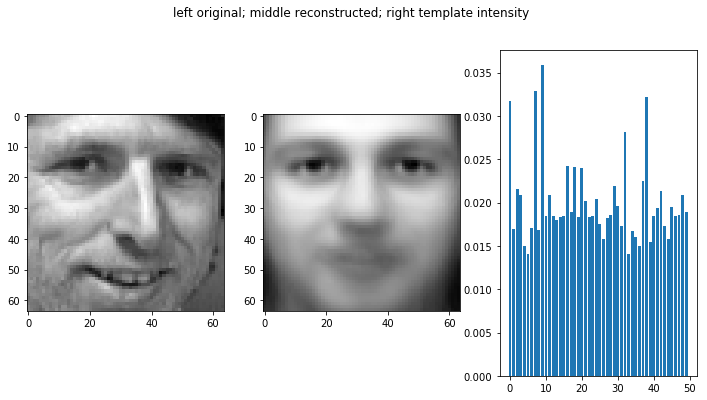

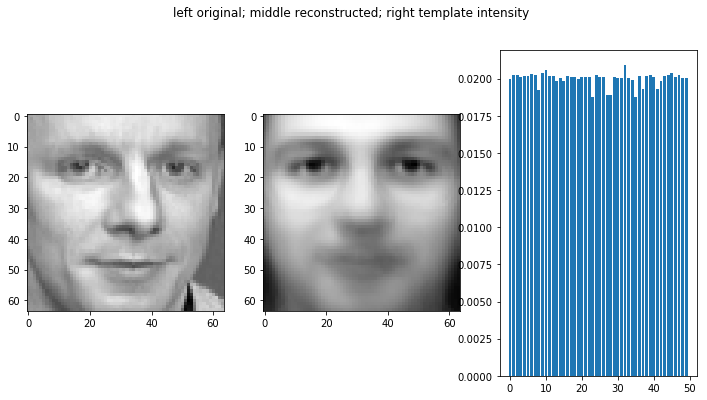

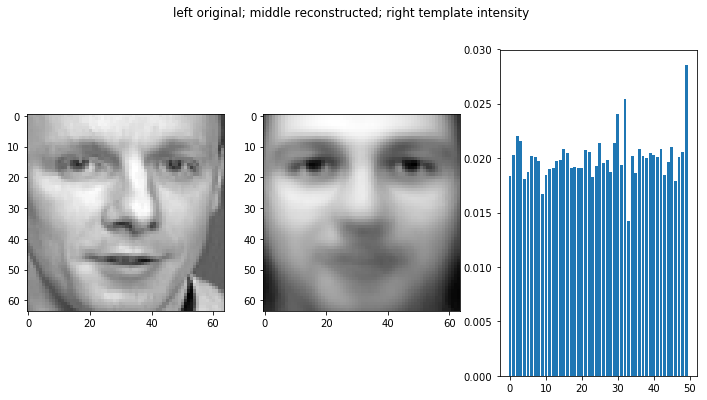

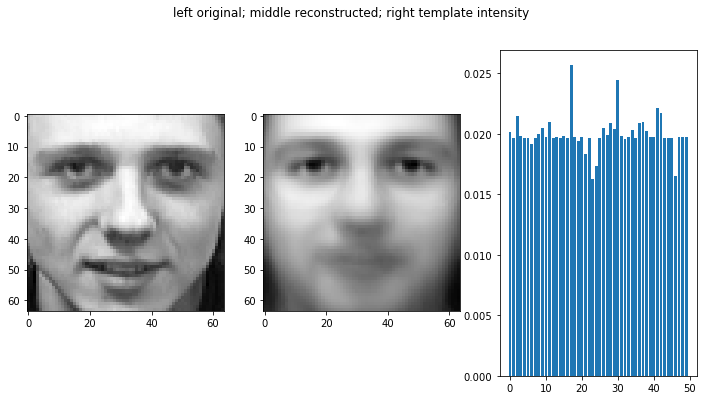

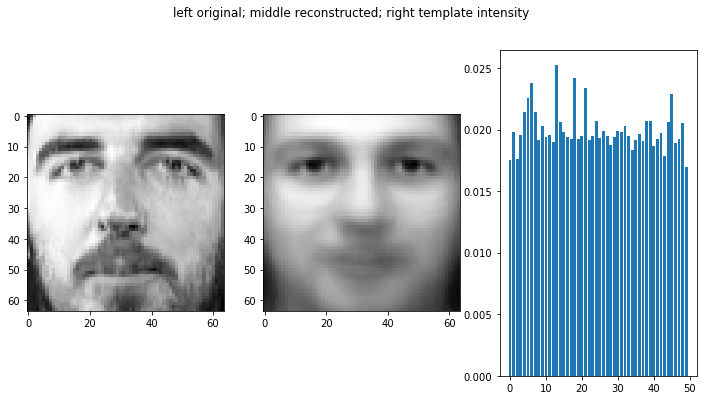

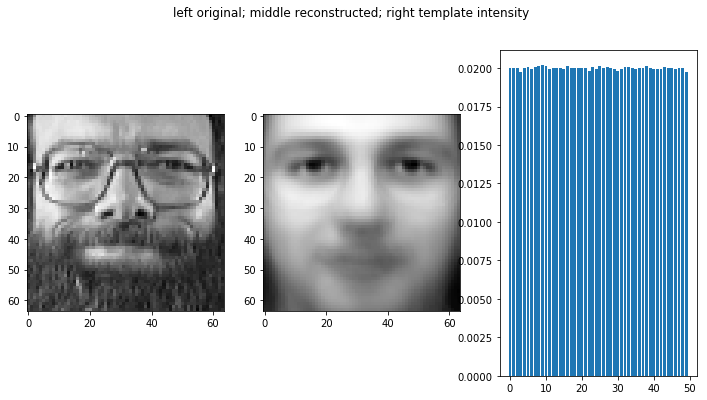

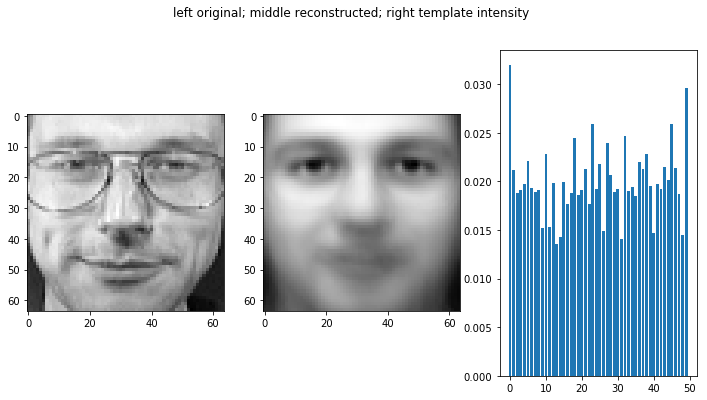

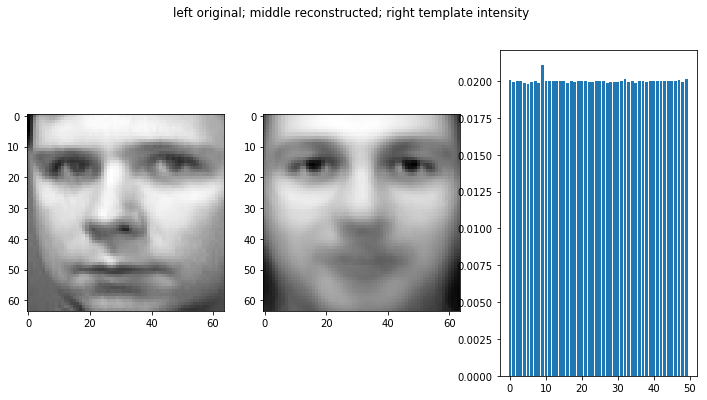

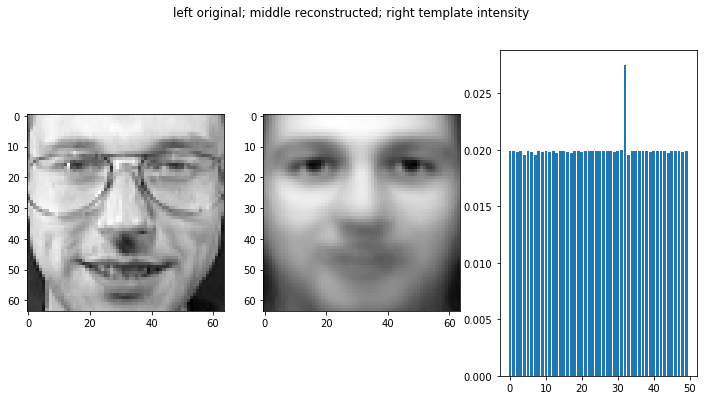

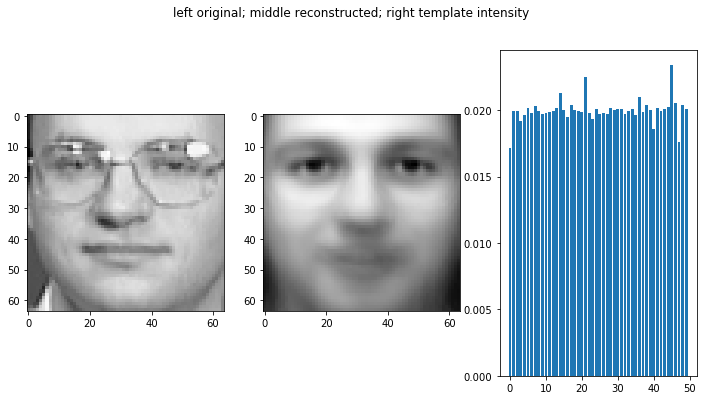

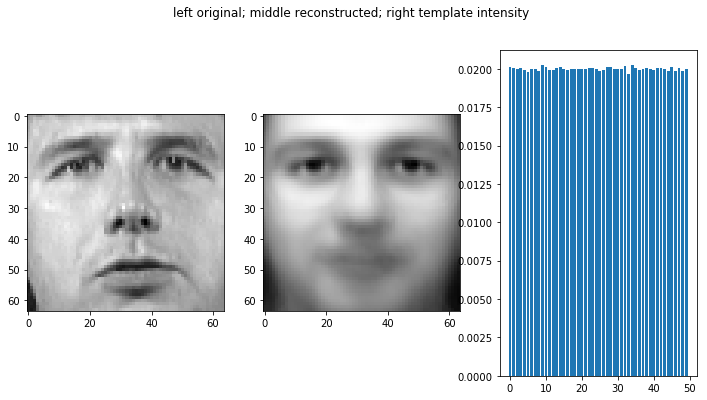

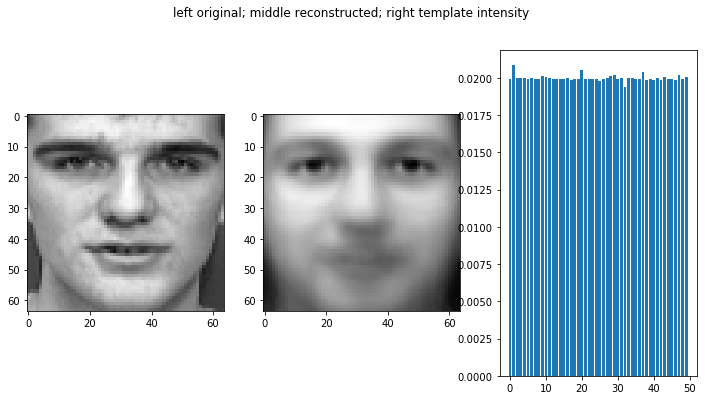

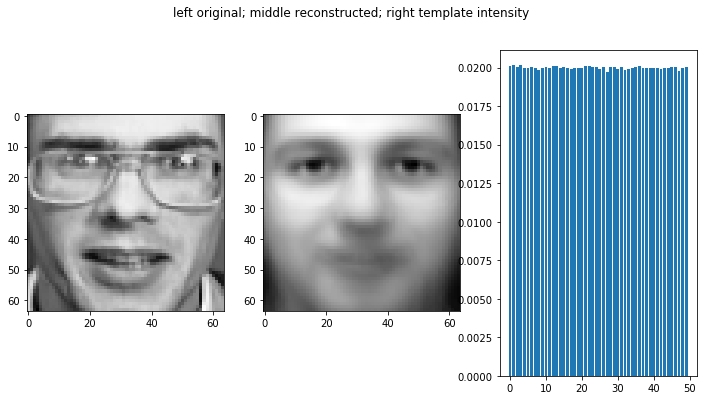

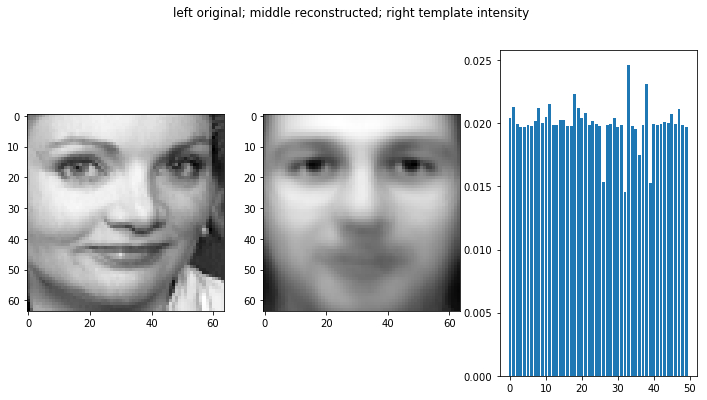

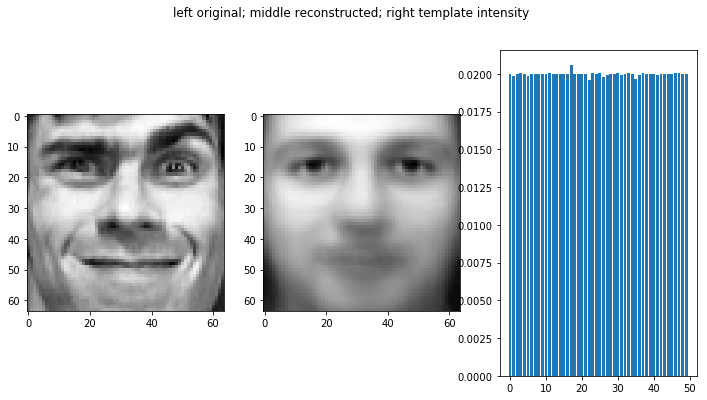

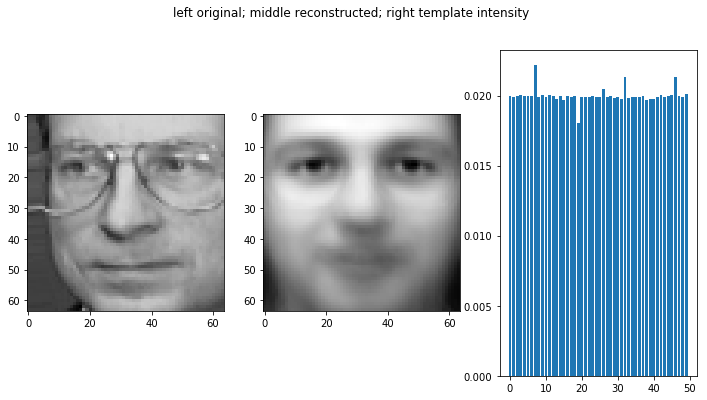

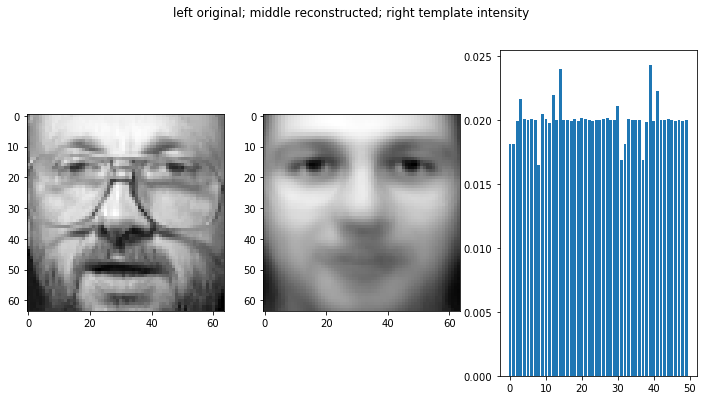

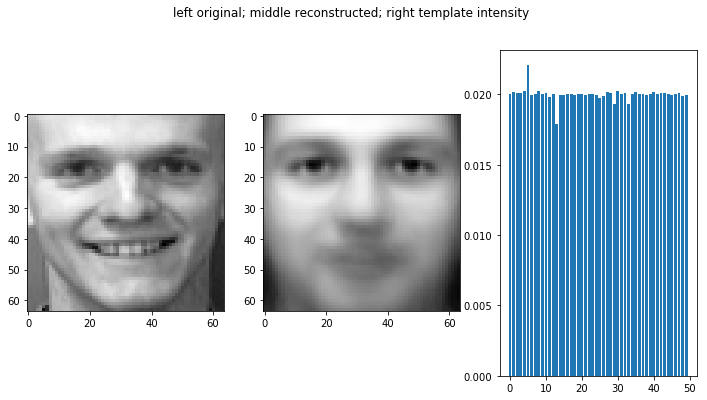

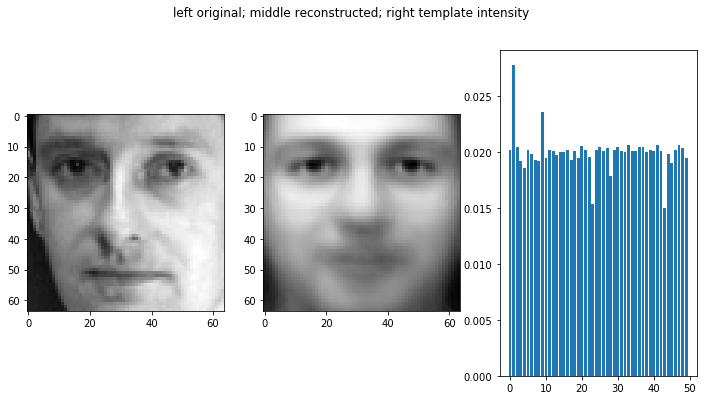

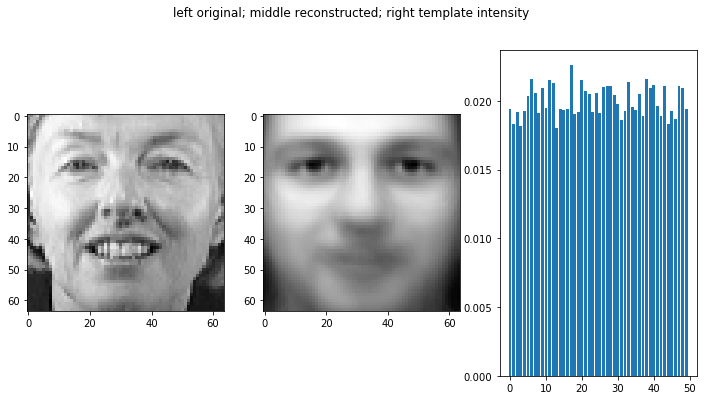

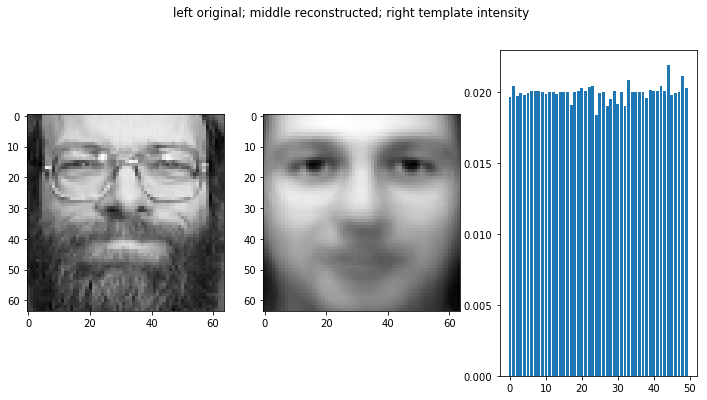

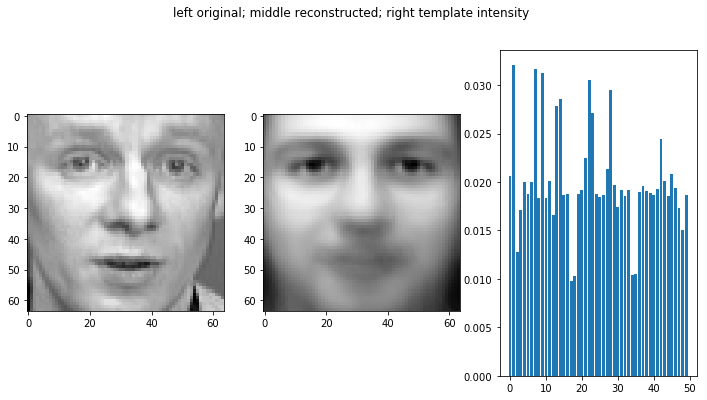

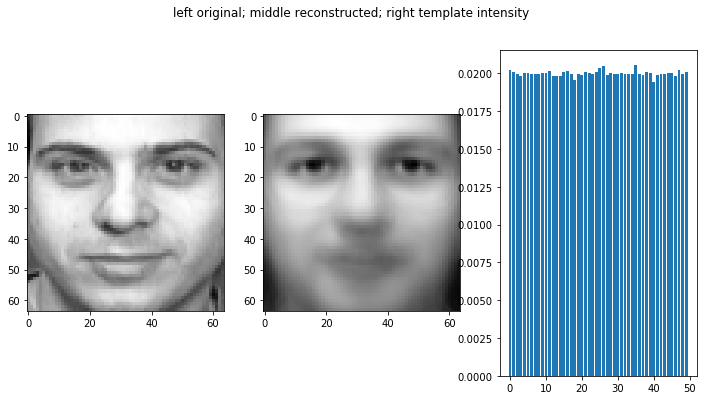

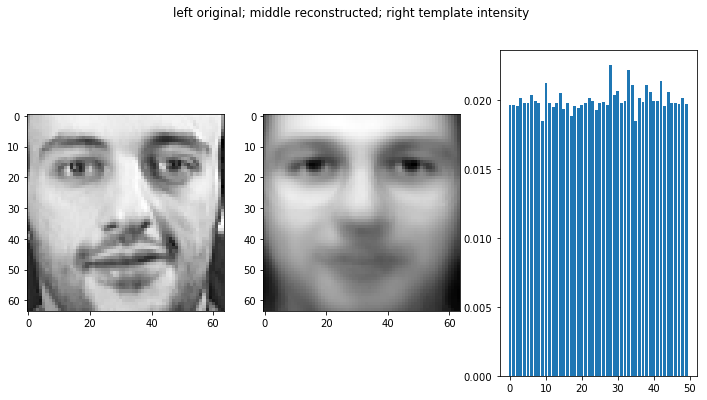

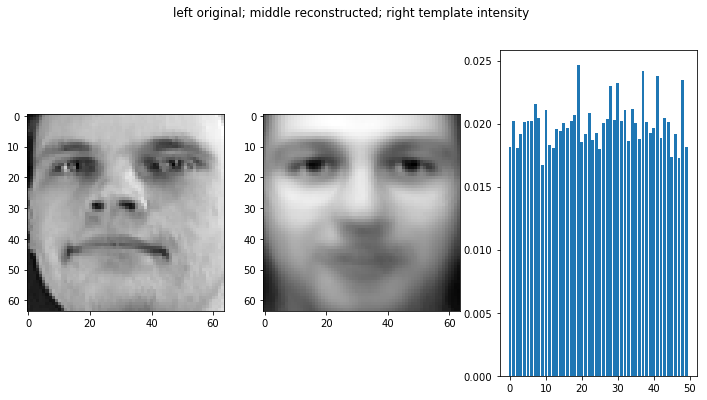

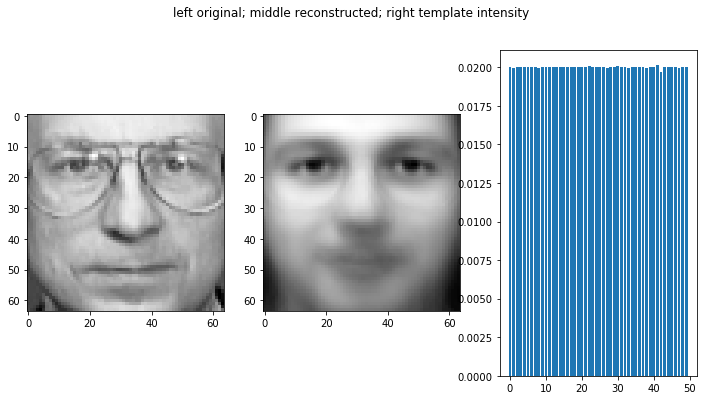

In [95]:
S = 30
sampled_inds = np.random.choice(np.arange(N), size=S, replace=False)

w_logits_i = tf.gather(w_logits, sampled_inds, axis = 0)
w_post_i = tfd.Dirichlet(tf.math.softplus(w_logits_i, ))
w_sample = w_post_i.sample()
x_hats = calculate_doc_probs2(w_sample, h_logits)@used_data

for s in range(S):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,6))
    fig.suptitle('left original; middle reconstructed; right template intensity')
    x_hat = f_inv_norm(x_hats[s, :], f_data_array)
    x = f_data_array[sampled_inds[s], :]
    ax1.imshow(np.reshape(-x, (64, 64)), cmap=plt.cm.binary)
    ax2.imshow(np.reshape(-x_hat, (64, 64)), cmap=plt.cm.binary)
    ax3.bar(np.arange(T), tf.math.softmax(tf.gather(w_logits_i, s, axis = 0)))
    plt.show()

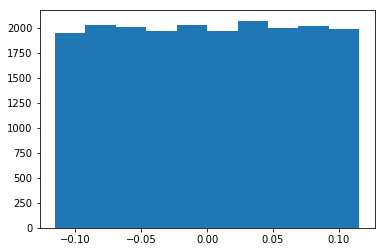

In [28]:
plt.hist(h_logits.numpy().flatten())
plt.show()

so KL divergence annealing doesn't really work at all. Annealing up to a constant < 1 is not even the original objective anymore

In [591]:
T = 50
N = 400
V = 4096
S = 100
w_logits = tf.Variable(tf.initializers.GlorotUniform()((N, T)))
w_norm = tf.Variable(tf.initializers.Zeros()((N, 1)))
h_logits = tf.Variable(tf.initializers.GlorotUniform()((T, N)))
opt = tf.optimizers.Adam(1e-2)

w_p = 1.0
w_prior = tfd.Dirichlet(tf.ones((T, )) * w_p)

In [592]:
epochs = 10000
burn_in = 5000
loss_records = []
tqdm_range = tqdm(range(epochs))
used_data = f_data_norm
# anneal_kl = tf.constant(np.logspace(-9, -4, epochs), 'float32')


for e in tqdm_range:
    i = np.random.choice(np.arange(N), size=S, replace=False)
    with tf.GradientTape() as tape:
        w_logits_i = tf.gather(w_logits, i, axis = 0)
        w_norm_i = tf.gather(w_norm, i, axis = 0)
        w_post_i = tfd.Dirichlet(tf.math.softmax(w_logits_i, axis = -1)/ tf.math.exp(w_norm_i))
        w_sample = w_post_i.sample()
        prob_mat = calculate_doc_probs2(w_sample, h_logits)
        kl = tfd.kl_divergence(w_post_i, w_prior)
        elbo = tf.keras.losses.MAE(prob_mat@used_data, used_data[i, :]) + kl #* anneal_kl[e]
        loss = tf.reduce_mean(elbo)
    
    if e >= burn_in:
        grads = tape.gradient(loss, [w_logits, h_logits, w_norm])
        opt.apply_gradients(zip(grads, [w_logits, h_logits, w_norm]))
    else:
        grads = tape.gradient(loss, [w_logits, h_logits])
        opt.apply_gradients(zip(grads, [w_logits, h_logits]))
    loss_records.append(tf.reduce_sum(loss))
    tqdm_range.set_description("loss: {:.2f}".format(tf.reduce_sum(loss).numpy()), refresh = True)

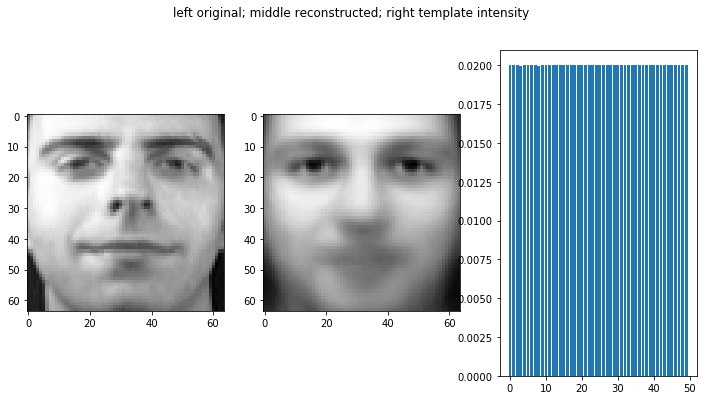

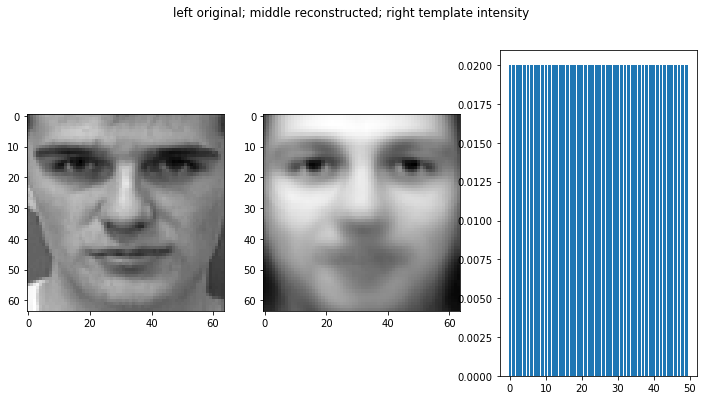

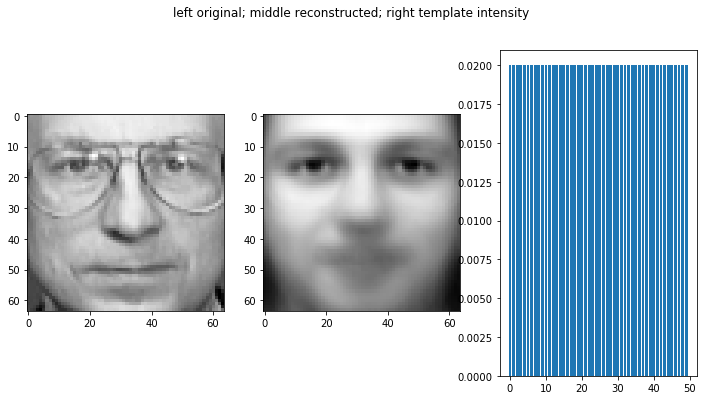

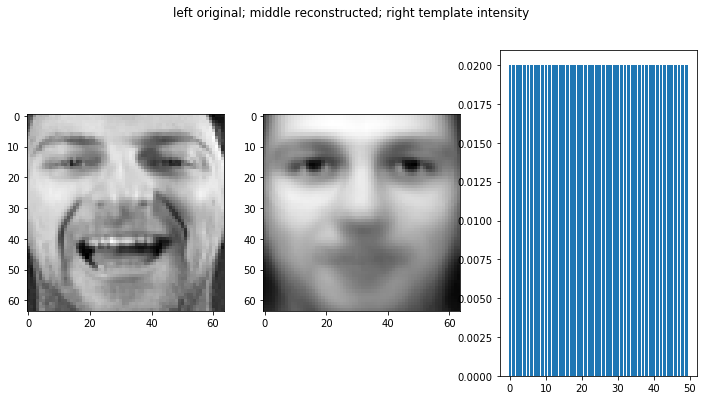

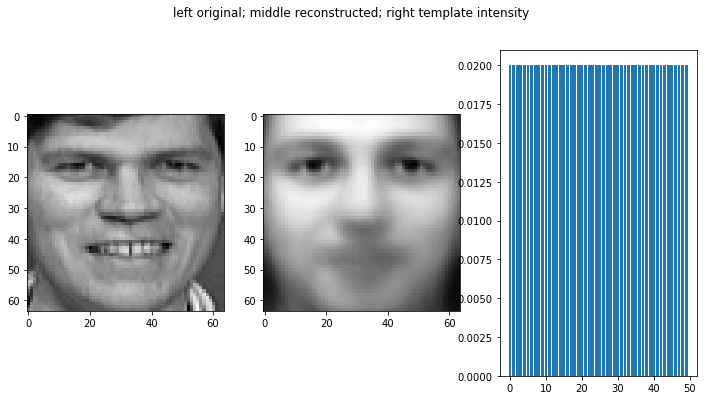

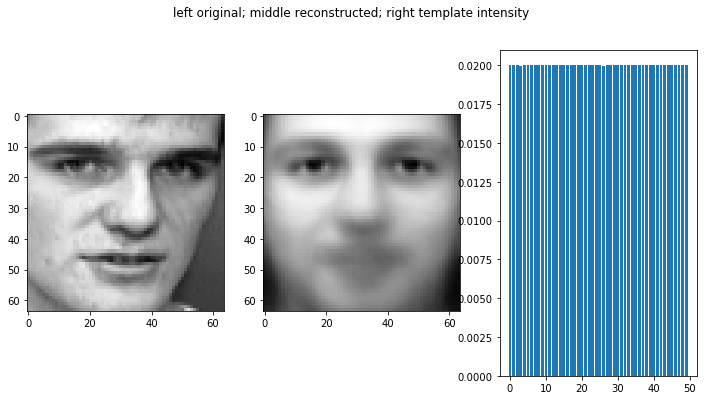

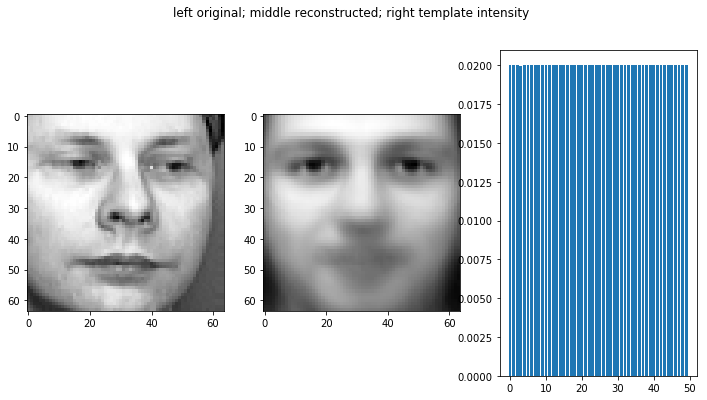

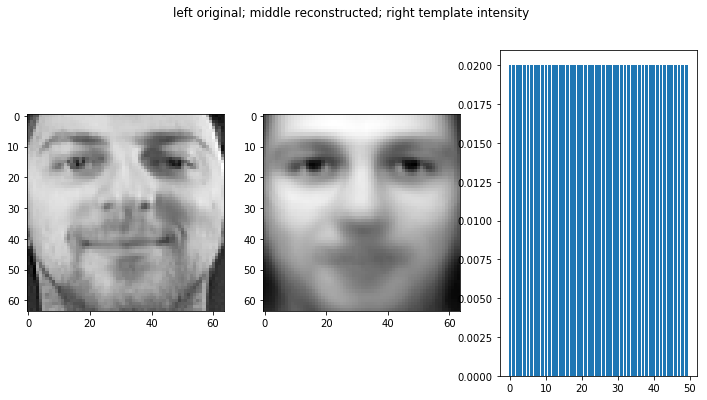

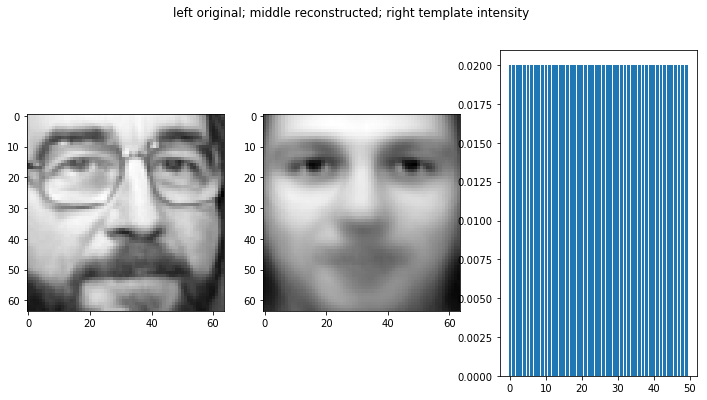

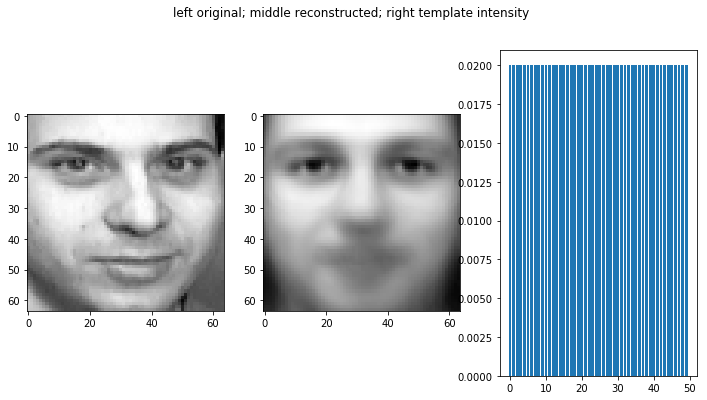

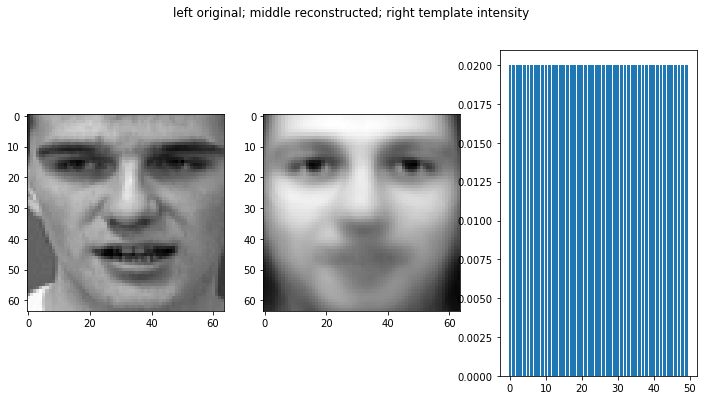

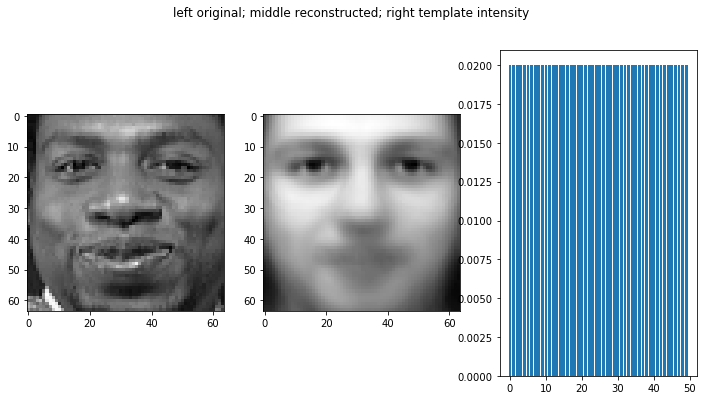

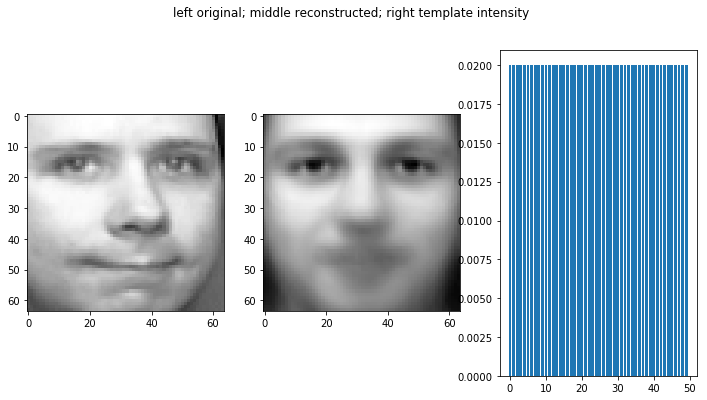

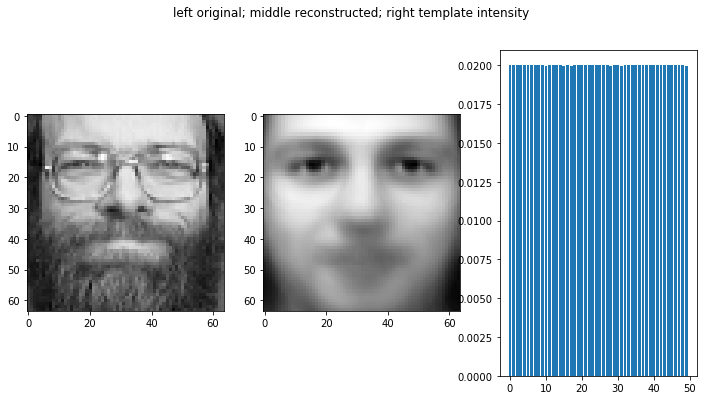

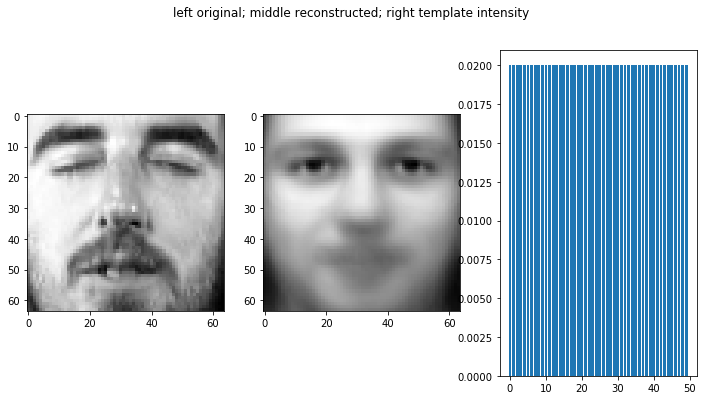

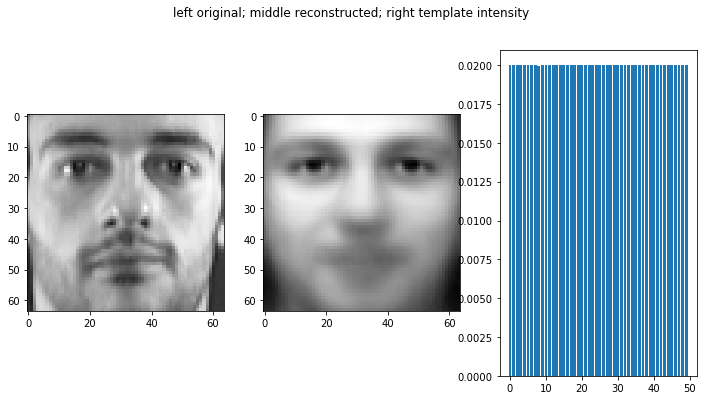

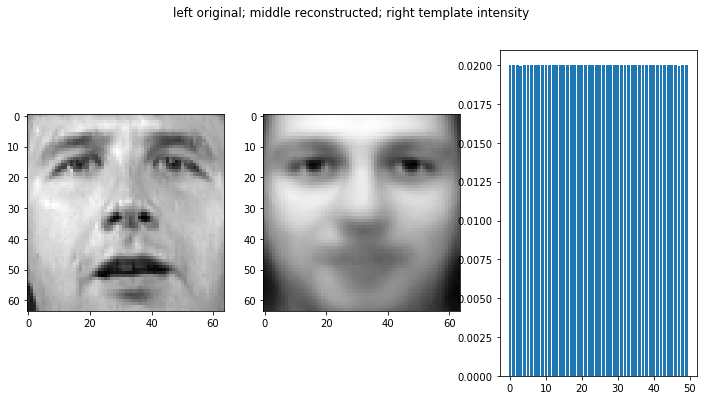

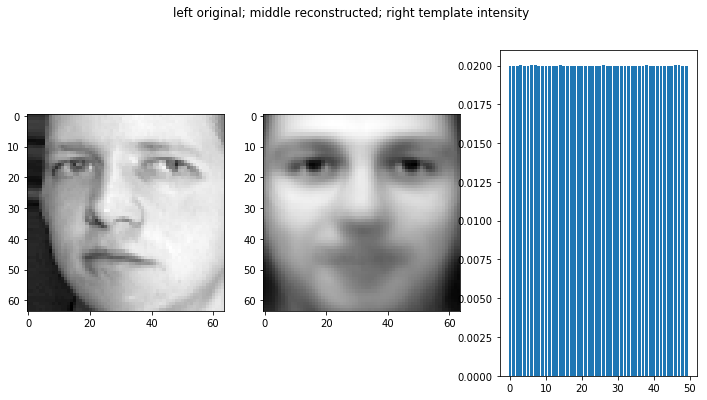

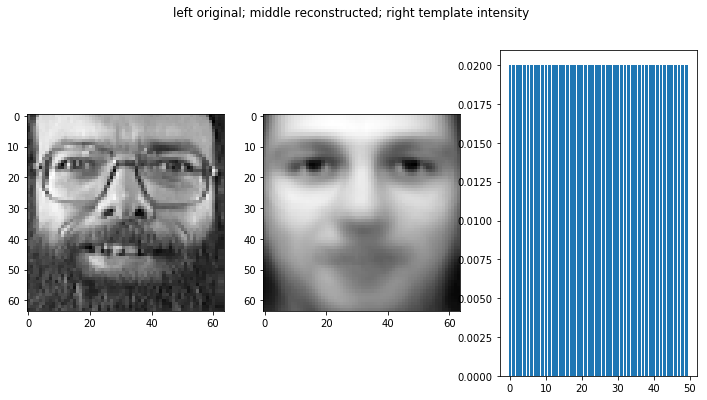

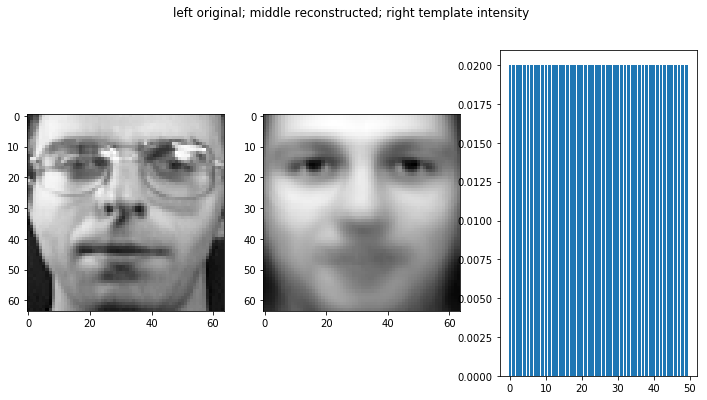

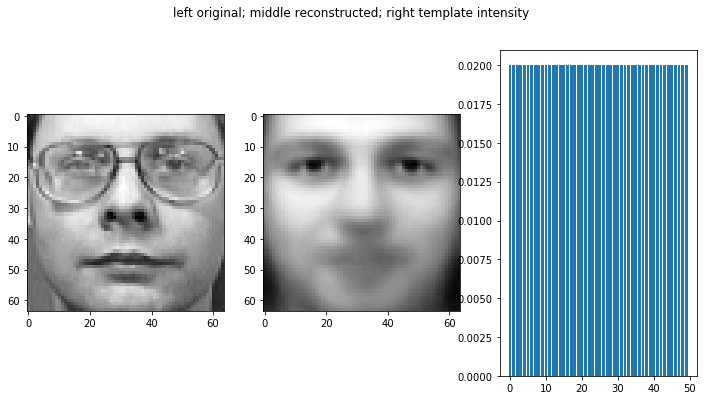

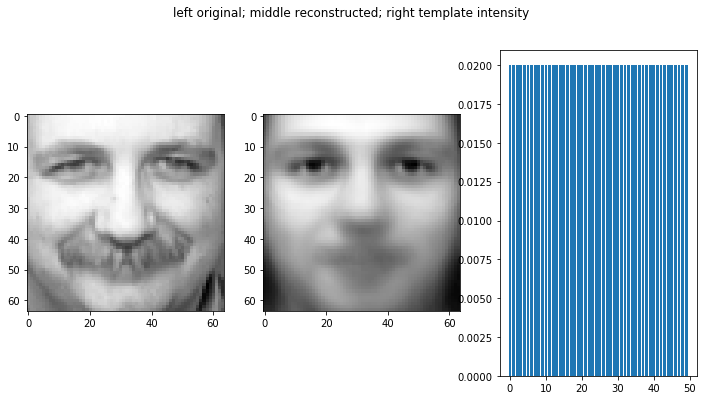

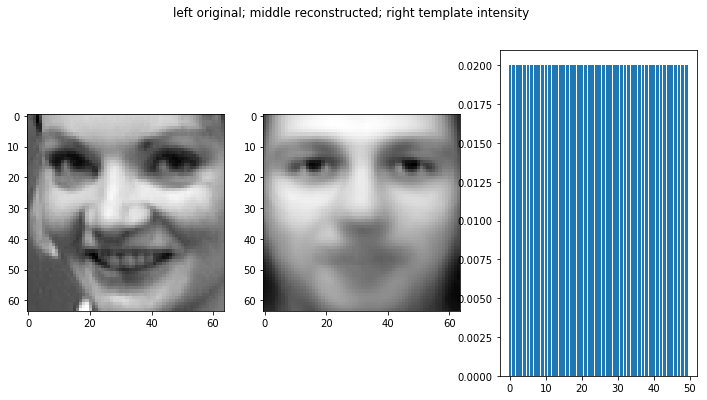

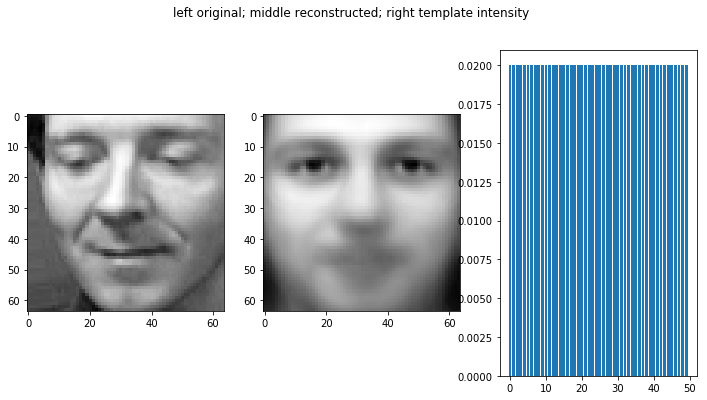

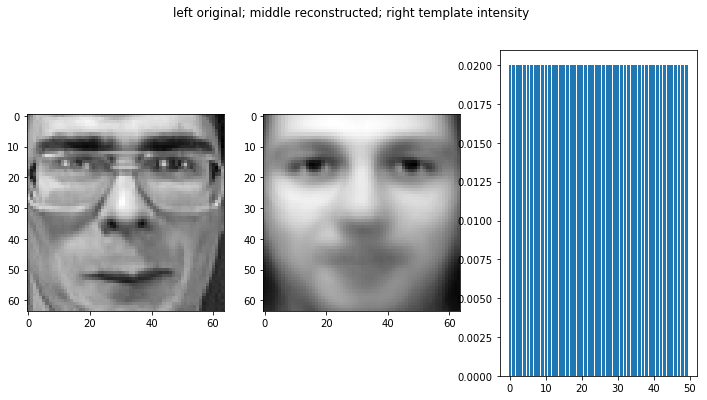

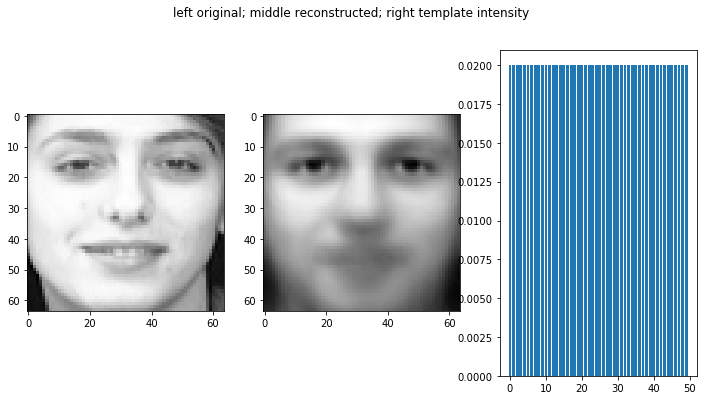

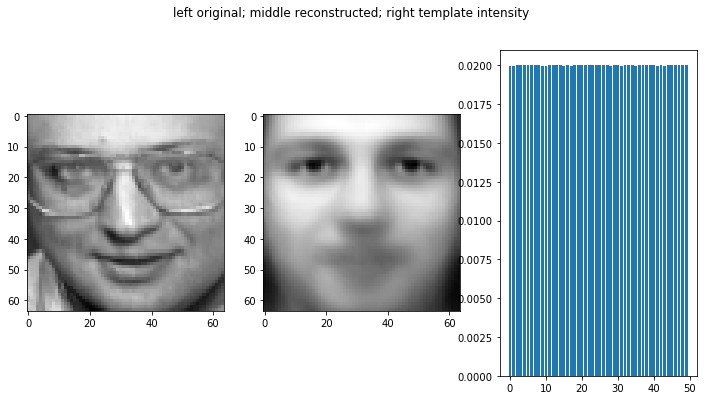

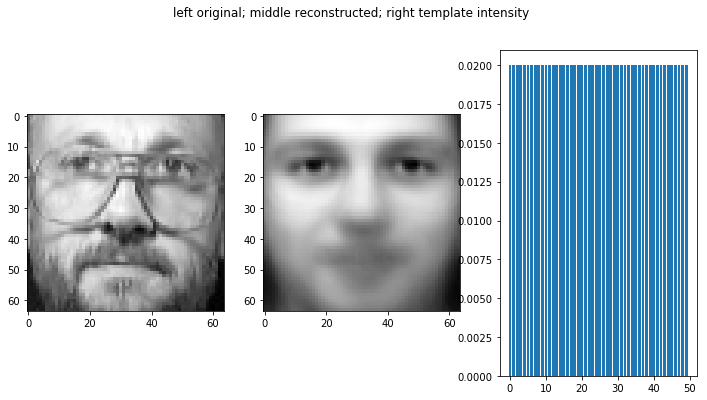

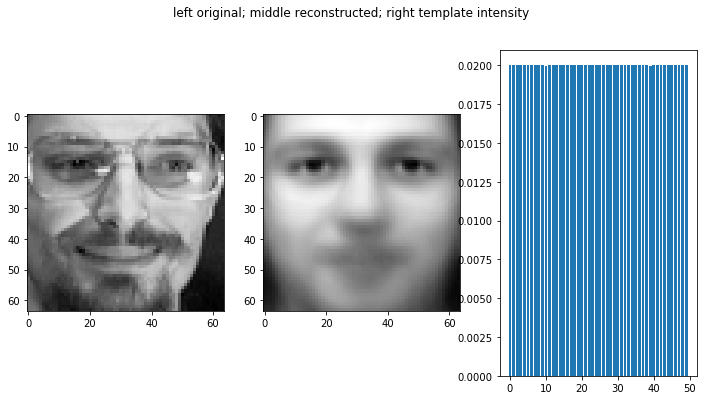

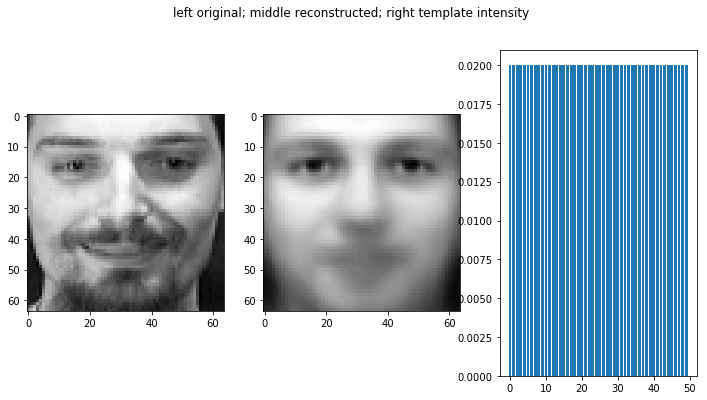

In [596]:
S = 30
sampled_inds = np.random.choice(np.arange(N), size=S, replace=False)

w_logits_i = tf.gather(w_logits, sampled_inds, axis = 0)
w_post_i = tfd.Dirichlet(tf.math.softmax(w_logits_i, axis = -1) /tf.gather(tf.math.exp(w_norm), sampled_inds, axis = 0))
w_sample = w_post_i.sample()
x_hats = calculate_doc_probs2(w_sample, h_logits)@used_data

for s in range(S):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,6))
    fig.suptitle('left original; middle reconstructed; right template intensity')
    x_hat = f_inv_norm(x_hats[s, :], f_data_array)
    x = f_data_array[sampled_inds[s], :]
    ax1.imshow(np.reshape(-x, (64, 64)), cmap=plt.cm.binary)
    ax2.imshow(np.reshape(-x_hat, (64, 64)), cmap=plt.cm.binary)
    ax3.bar(np.arange(T), tf.math.softmax(tf.gather(w_logits_i, s, axis = 0)))
    plt.show()

Amortize the face topics distribution inference

In [499]:
T = 100
N = 400
V = 4096
S = 100
J = 100
h_logits = tf.Variable(tf.initializers.GlorotUniform()((T, N)))
opt = tf.optimizers.Adam(1e-4)
w_p = 1.0
w_prior = tfd.Dirichlet(tf.ones((T, )) * w_p)

In [501]:
def make_encoder(units, input_dim, T, activation = 'relu'):
    inputs = tf.keras.Input((input_dim,))
    x=inputs
    for u in units:
        x = tf.keras.layers.Dense(u, activation=activation)(x)
    
    x = tf.keras.layers.Dense(T, activation = None)(x)
    return tf.keras.Model(inputs=inputs,outputs=x)

In [502]:
w_encoder = make_encoder([1024, 512, 128], V, T)

In [495]:
epochs = 100
loss_records = []
tqdm_range = tqdm(range(epochs))
used_data = f_data_norm
anneal_kl = tf.constant(np.logspace(-3, 0, epochs), 'float32')

for e in tqdm_range:
    i = np.random.choice(np.arange(N), size=S, replace=False)
    with tf.GradientTape() as tape:
        w_logits_i = w_encoder(used_data[i, :])
        w_post_i = tfd.Dirichlet(tf.math.exp(w_logits_i))
        w_sample = w_post_i.sample(J)
        kl = tfd.kl_divergence(w_post_i, w_prior)
#         kl_hat = w_post_i.log_prob(w_sample) - w_prior.log_prob(w_sample)
        
        prob_mat = calculate_doc_probs2(w_sample, h_logits)
        loss = tf.reduce_mean(tf.keras.losses.MAE(prob_mat@used_data, used_data[i, :])) #+ tf.reduce_mean(kl) 
    
    grads = tape.gradient(loss, [h_logits, ] + w_encoder.trainable_variables)
    opt.apply_gradients(zip(grads, [h_logits, ] + w_encoder.trainable_variables))
    loss_records.append(tf.reduce_sum(loss))
    tqdm_range.set_description("loss: {:.2f}".format(tf.reduce_sum(loss).numpy()), refresh = True)


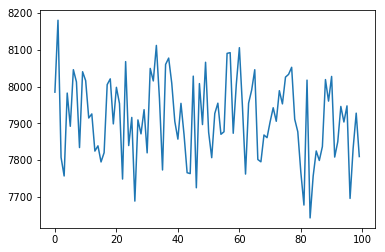

In [497]:
plt.plot(loss_records)
plt.show()

Posterior Collapse everywhere

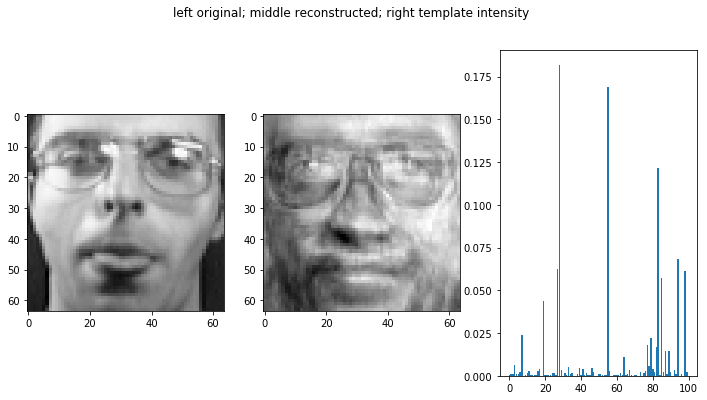

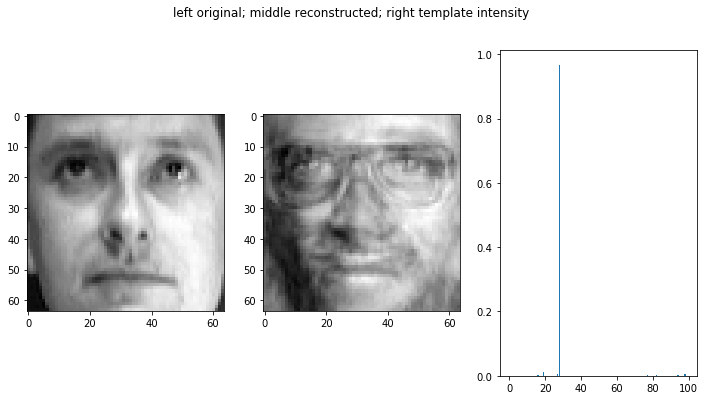

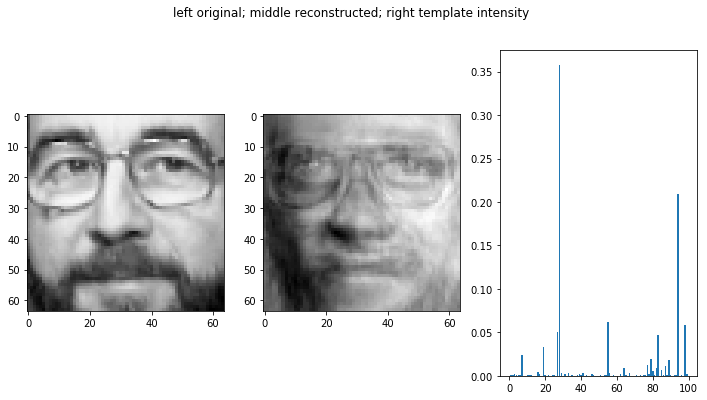

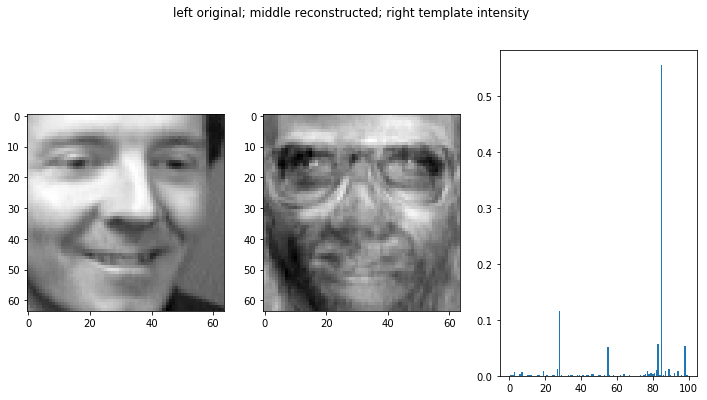

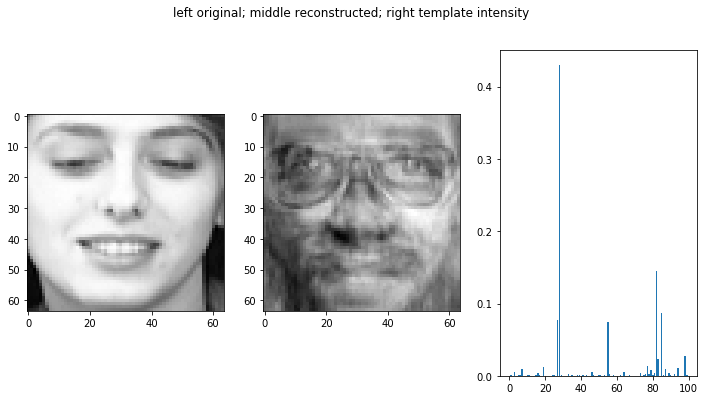

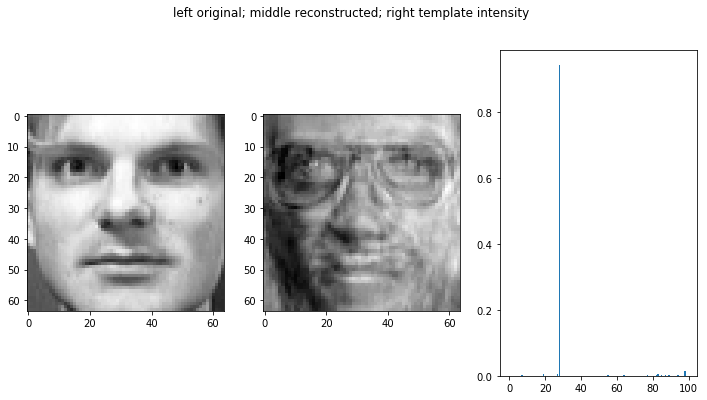

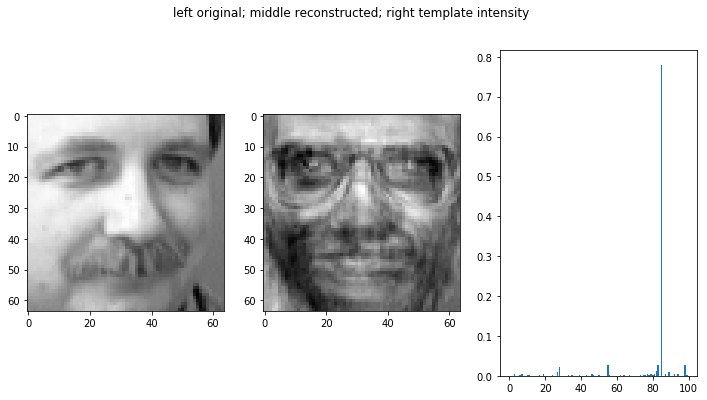

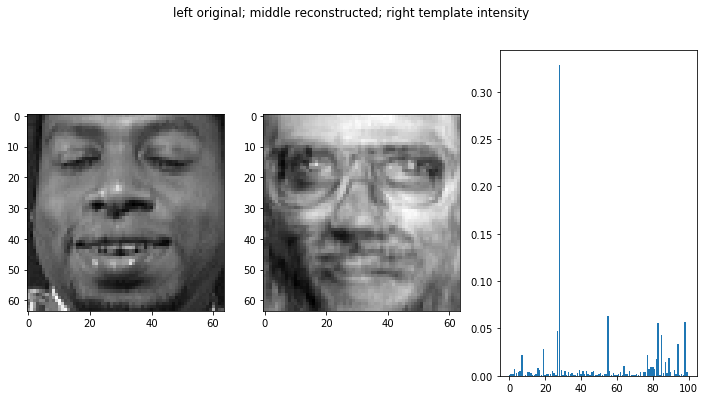

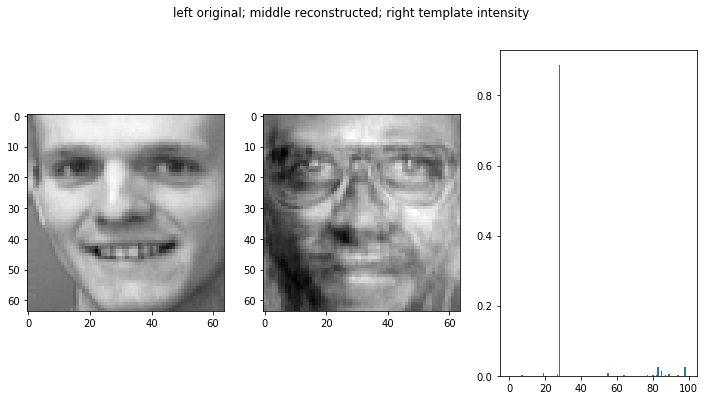

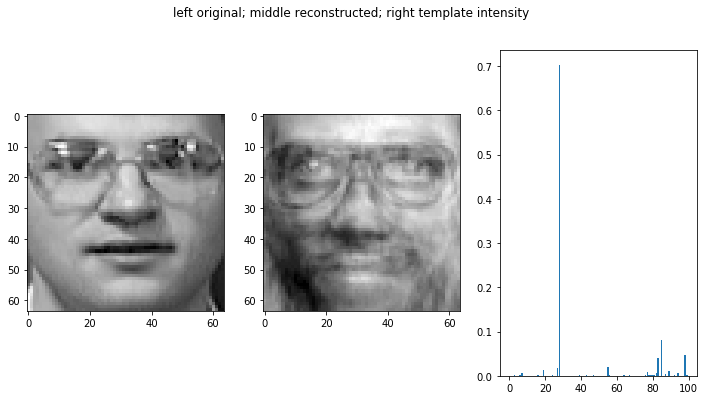

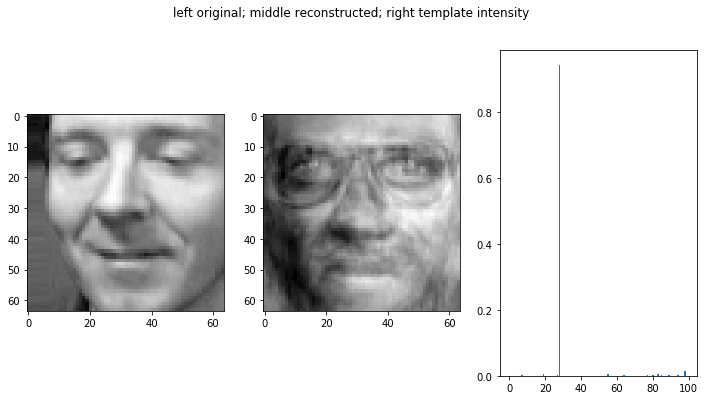

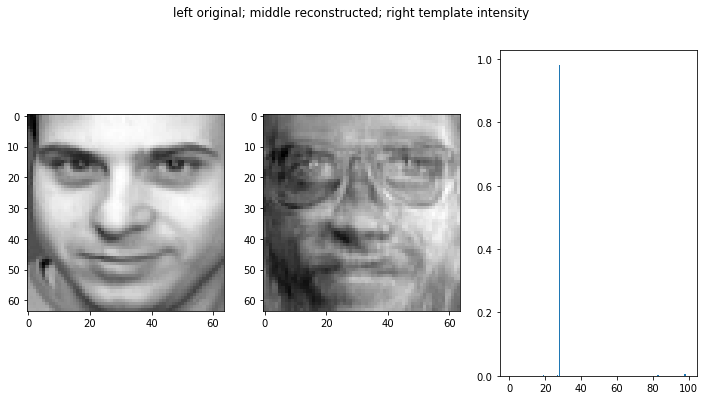

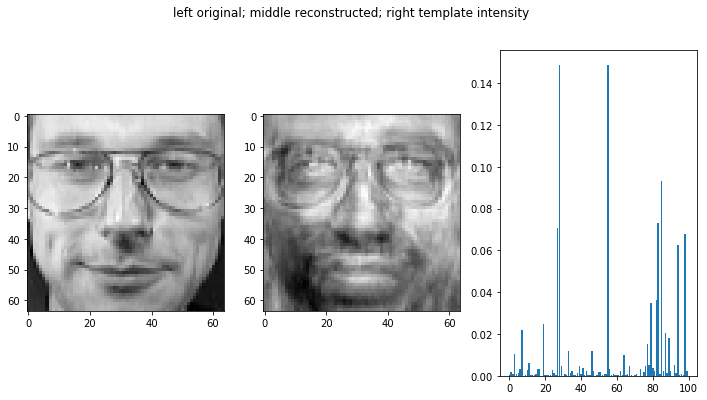

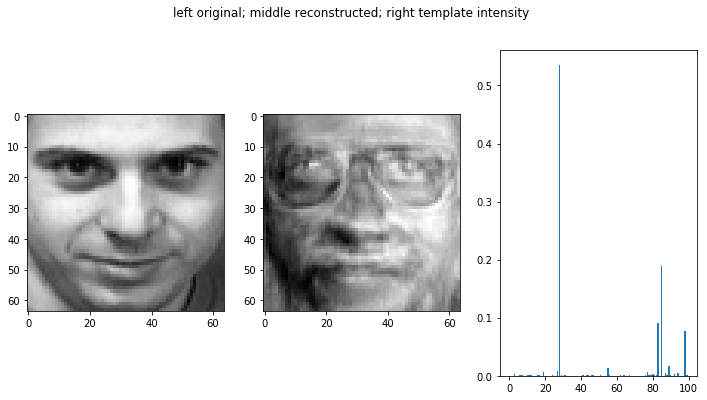

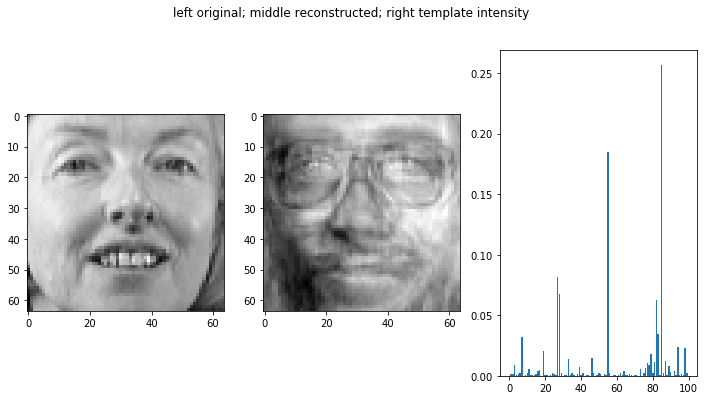

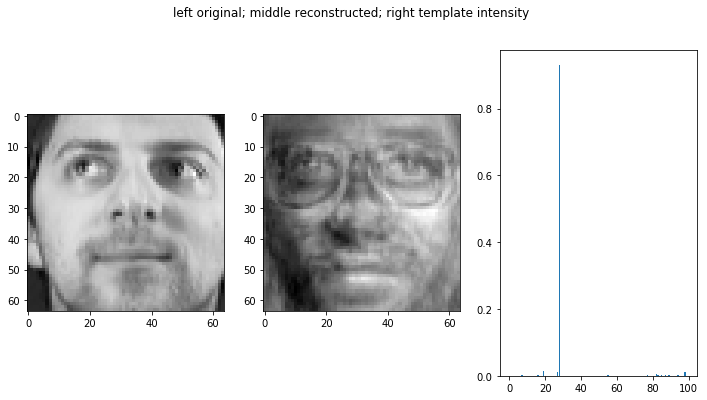

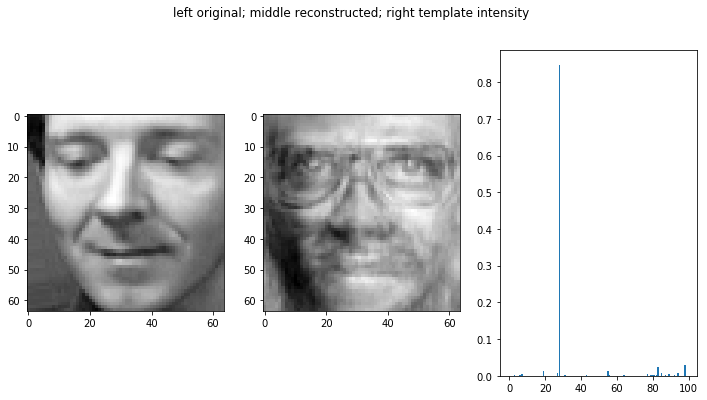

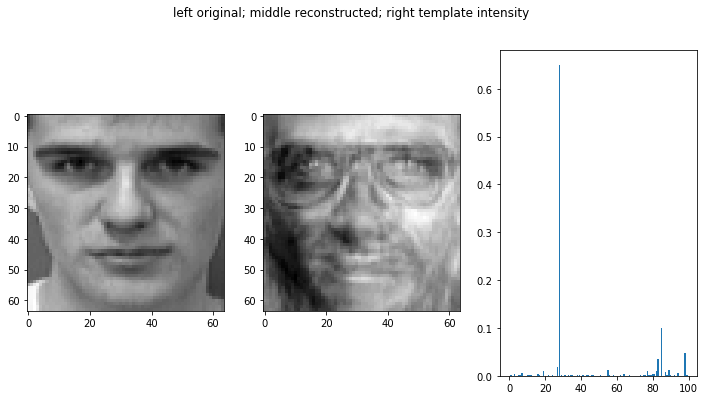

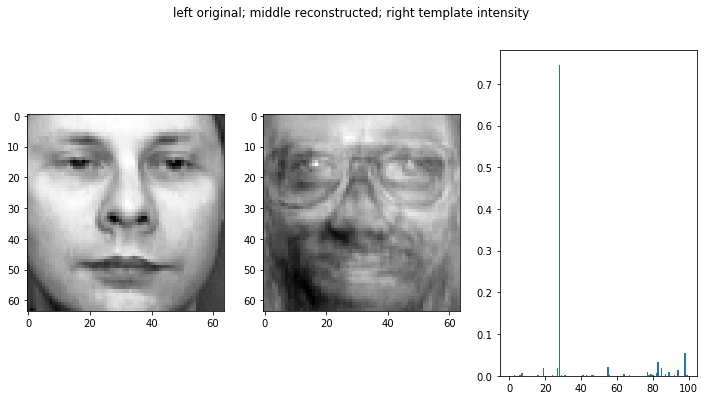

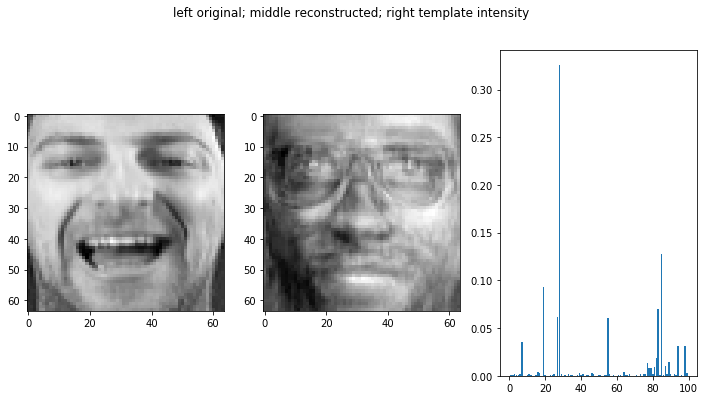

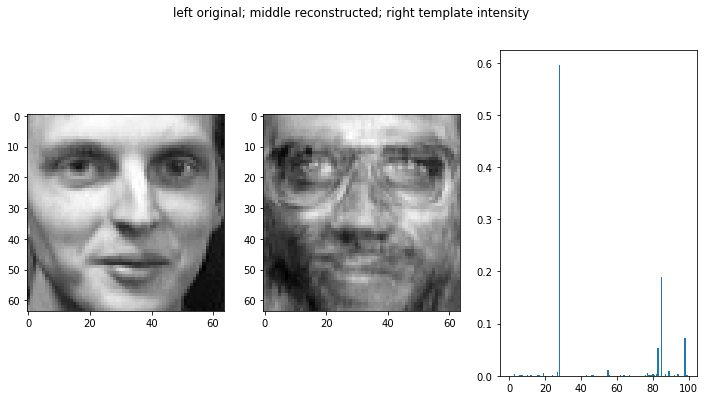

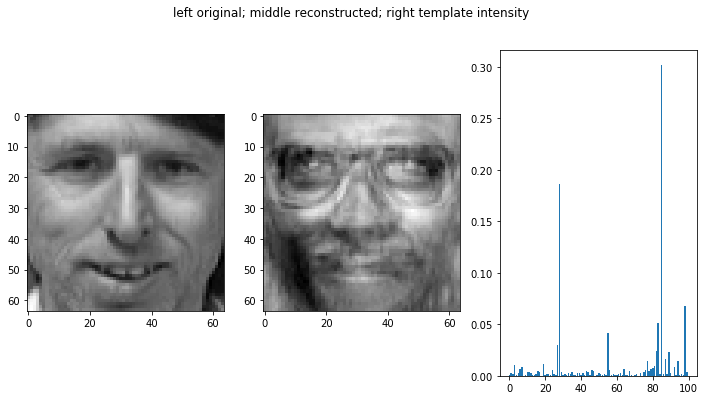

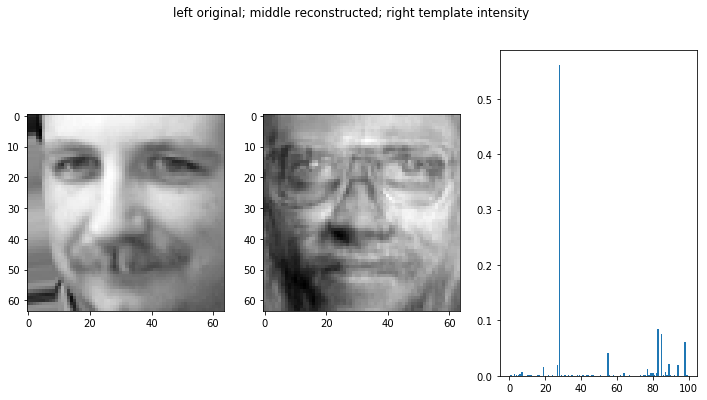

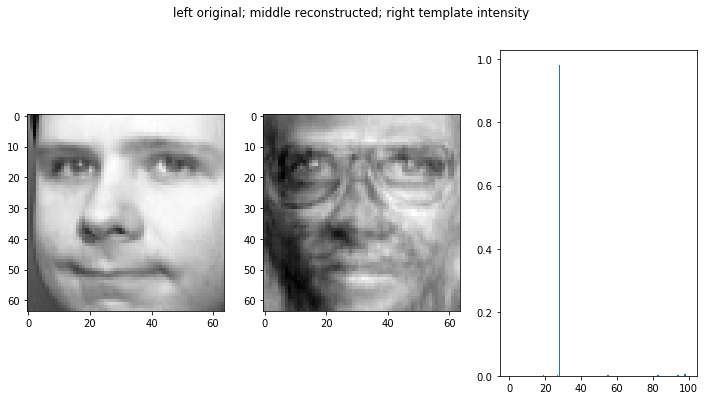

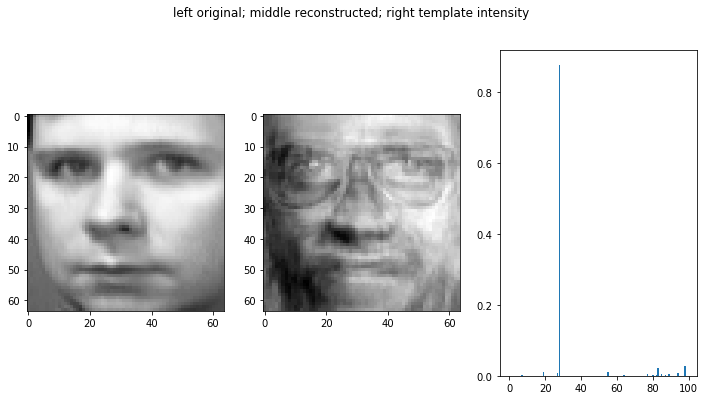

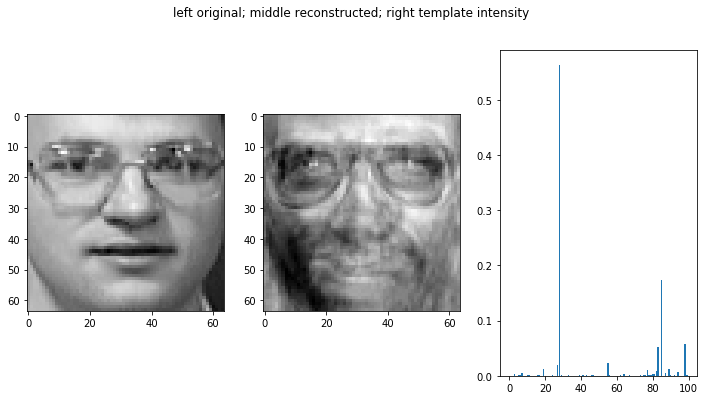

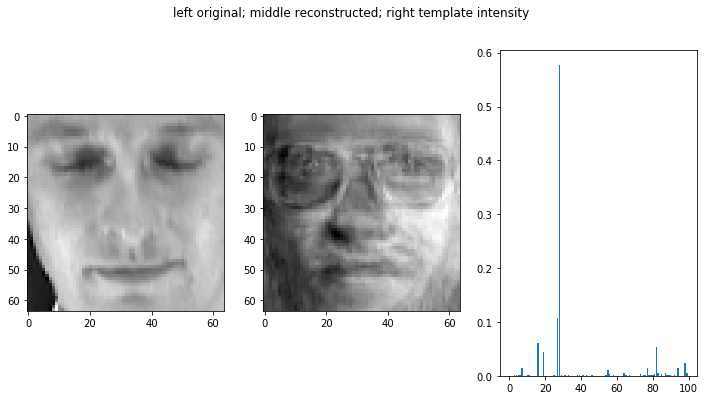

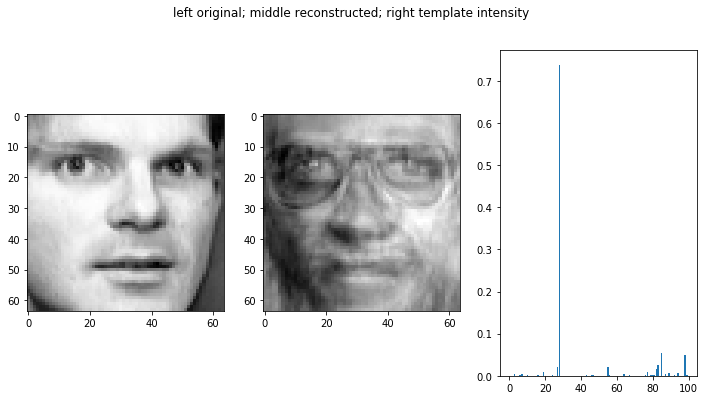

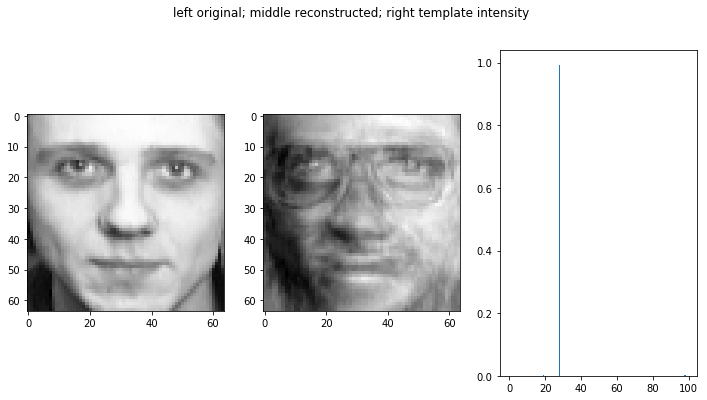

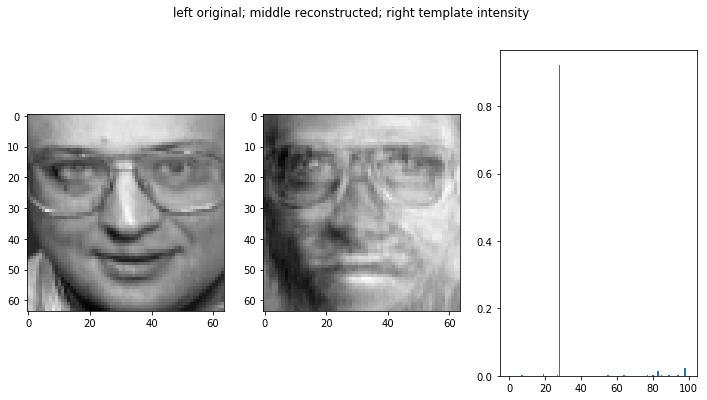

In [498]:
S = 30
sampled_inds = np.random.choice(np.arange(N), size=S, replace=False)

w_logits_i = w_encoder(f_data_array[sampled_inds, :])
w_post_i = tfd.Dirichlet(tf.math.softplus(w_logits_i))
w_sample = w_post_i.sample()

for s in range(S):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,6))
    fig.suptitle('left original; middle reconstructed; right template intensity')
    x_hat = f_inv_norm(calculate_doc_probs2(tf.reshape(w_sample[s], (1, -1)), h_logits)@f_data_norm, f_data_norm)
    x = f_data_array[sampled_inds[s], :]
    ax1.imshow(np.reshape(-x, (64, 64)), cmap=plt.cm.binary)
    ax2.imshow(np.reshape(-x_hat, (64, 64)), cmap=plt.cm.binary)
    ax3.bar(np.arange(T), tf.math.softmax(tf.gather(w_logits_i, s, axis = 0)))
    plt.show()